In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc
import seaborn as sns
from cnmf import cNMF
import os 
import sys
import pickle
from matplotlib import gridspec

sys.path.append('../../../Code/scsim2')
from scsim2 import scsim2

sys.path.append('../../../Code')
from utils import starcat, df_col_corr

def process(a):
    sc.pp.highly_variable_genes(a, flavor='seurat_v3', n_top_genes=2000)
    a.raw = a.copy()
    sc.pp.normalize_per_cell(a, counts_per_cell_after=10000)
    a = a[:,a.var['highly_variable']]
    sc.pp.scale(a, zero_center=False)
    sc.pp.pca(a)
    sc.pl.pca_variance_ratio(a, log=True)
    sc.pp.neighbors(a, n_neighbors=10, n_pcs=12)
    sc.tl.umap(a)
    sc.pl.umap(a)
    return(a)

from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/TCAT/Simulation_Benchmark


# Simulation 2

In [5]:
datadir = '../../../Data/PerDataset/TCAT_Simulation/Deloc1.5_new'
if not os.path.exists(datadir): os.mkdir(datadir)

In [3]:
figdir = '../../../Figures/Components'

### Prepare catalog of GEPs

In [5]:
nidentity = 10
nactivity = 10

In [5]:
simmod_catalog = scsim2(seed=36, diffexploc=1.5)
simmod_catalog.simulate(ncells=10000, ngenes=10000, nidentities=nidentity, activity_pct=[.3]*nactivity,
                activity_min=[.1]*nactivity, activity_max=[.7]*nactivity,
                activity_identities=[list(range(1,nidentity+1))]*nactivity,
                pct_doublets=.05)

Simulating cells
Simulating gene params
Simulating DE
Simulating doublets
Simulating cell-gene means
Adjusting means
Simulating counts


In [6]:
simmod_catalog.counts.to_csv('{d}/refcatalog_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_catalog.usage.to_csv('{d}/refcatalog_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_catalog.spectra.to_csv('{d}/refcatalog_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_catalog.geneparams.to_csv('{d}/refcatalog_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_catalog.cellparams.to_csv('{d}/refcatalog_cellparams.tsv'.format(d=datadir), sep='\t')

In [13]:
catalog_pkl_fn = '{d}/gep_catalog.pkl'.format(d=datadir)

In [8]:
with open(catalog_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_catalog, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open(catalog_pkl_fn, 'rb') as handle:
    simmod_catalog = pickle.load(handle)

### Prepare reference 1

In [9]:
simmod_ref1 = scsim2(seed=14, diffexploc=1.5)

nrefidentity = nidentity
nrefactivity = nactivity

thisdata = simmod_ref1
thisdata.cellparams, thisdata.usage = thisdata.get_usages(ncells=100000,
                                               nidentities=nrefidentity, activity_pct=[.3]*nrefactivity,
                                               activity_min=[.1]*nrefactivity, activity_max=[.7]*nrefactivity,
                                               activity_identities=[list(range(1,nidentity+1))]*nrefactivity,
                                               max_activity_total=.7)

ngenes = 9000
overlap = np.random.choice(simmod_catalog.geneparams.index, size=ngenes, replace=False)

thisdata.geneparams = simmod_catalog.geneparams.loc[simmod_catalog.geneparams.index.isin(overlap), :]
tokeep = [x for x in thisdata.geneparams if x in ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean'] or (x.split('.')[0] in thisdata.usage.columns)]
thisdata.geneparams = thisdata.geneparams.loc[:, tokeep]
thisdata.spectra = simmod_catalog.spectra.loc[thisdata.usage.columns, thisdata.geneparams.index]

thisdata.cellgenemean = thisdata.get_cell_gene_means()
thisdata.adjust_means_bcv()
thisdata.simulate_counts()
simmod_ref1 = thisdata

In [10]:
simmod_ref1.counts.to_csv('{d}/ref1_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref1.usage.to_csv('{d}/ref1_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref1.spectra.to_csv('{d}/ref1_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref1.geneparams.to_csv('{d}/ref1_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_ref1.cellparams.to_csv('{d}/ref1_cellparams.tsv'.format(d=datadir), sep='\t')

In [11]:
simmod_ref1.usage.head()

Identity_1  Identity_2  Identity_3  Identity_4  Identity_5  \
Cell_1         0.0         0.0         0.3         0.0         0.0   
Cell_2         0.0         0.0         0.0         0.0         0.0   
Cell_3         0.0         0.0         0.0         0.0         0.0   
Cell_4         0.0         0.3         0.0         0.0         0.0   
Cell_5         0.0         0.0         0.0         0.0         0.0   

        Identity_6  Identity_7  Identity_8  Identity_9  Identity_10  \
Cell_1    0.000000         0.0         0.0         0.0          0.0   
Cell_2    0.000000         0.0         0.3         0.0          0.0   
Cell_3    0.000000         0.0         0.0         0.3          0.0   
Cell_4    0.000000         0.0         0.0         0.0          0.0   
Cell_5    0.598864         0.0         0.0         0.0          0.0   

        Activity_1  Activity_2  Activity_3  Activity_4  Activity_5  \
Cell_1    0.171609    0.156114    0.000000    0.188487    0.000000   
Cell_2    0.000000    0.145541    0.000000    0.000000    0.000000   
Cell_3    0.167649    0.000000    0.000000    0.000000    0.147761   
Cell_4    0.000000    0.082642    0.127933    0.121815    0.000000   
Cell_5    0.000000    0.000000    0.131360    0.000000    0.000000   

        Activity_6  Activity_7  Activity_8  Activity_9  Activity_10  
Cell_1    0.000000    0.000000    0.183790    0.000000          0.0  
Cell_2    0.000000    0.243643    0.000000    0.310816          0.0  
Cell_3    0.155743    0.102514    0.000000    0.126334          0.0  
Cell_4    0.000000    0.107295    0.260315    0.000000          0.0  
Cell_5    0.000000    0.269776    0.000000    0.000000          0.0

In [ ]:
ref1_pkl_fn = '{d}/ref1.pkl'.format(d=datadir)

In [13]:
with open(ref1_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_ref1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(ref1_pkl_fn, 'rb') as handle:
    simmod_ref1 = pickle.load(handle)

### Prepare reference 2

In [15]:
simmod_ref2 = scsim2(seed=50, diffexploc=1.5)

nrefidentity = nidentity-4
nrefactivity = nactivity-4

thisdata.cellparams, thisdata.usage = thisdata.get_usages(ncells=100000,
                                               nidentities=nrefidentity, activity_pct=[.3]*nrefactivity,
                                               activity_min=[.1]*nrefactivity, activity_max=[.7]*nrefactivity,
                                               activity_identities=[list(range(1,nidentity+1))]*nrefactivity,
                                               max_activity_total=.7)

ngenes = 9000
overlap = np.random.choice(simmod_catalog.geneparams.index, size=ngenes, replace=False)

thisdata.geneparams = simmod_catalog.geneparams.loc[simmod_catalog.geneparams.index.isin(overlap), :]
tokeep = [x for x in thisdata.geneparams if x in ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean'] or (x.split('.')[0] in thisdata.usage.columns)]
thisdata.geneparams = thisdata.geneparams.loc[:, tokeep]
thisdata.spectra = simmod_catalog.spectra.loc[thisdata.usage.columns, thisdata.geneparams.index]

thisdata.cellgenemean = thisdata.get_cell_gene_means()
thisdata.adjust_means_bcv()
thisdata.simulate_counts()
simmod_ref2 = thisdata

In [16]:
simmod_ref2.counts.to_csv('{d}/ref2_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref2.usage.to_csv('{d}/ref2_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref2.spectra.to_csv('{d}/ref2_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref2.geneparams.to_csv('{d}/ref2_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_ref2.cellparams.to_csv('{d}/ref2_cellparams.tsv'.format(d=datadir), sep='\t')

In [17]:
simmod_ref2.usage.head()

Identity_1  Identity_2  Identity_3  Identity_4  Identity_5  \
Cell_1         0.0         0.0         0.0         0.0         0.3   
Cell_2         0.0         0.0         0.0         0.3         0.0   
Cell_3         0.0         0.0         0.0         0.0         1.0   
Cell_4         0.0         0.3         0.0         0.0         0.0   
Cell_5         0.0         0.0         1.0         0.0         0.0   

        Identity_6  Activity_1  Activity_2  Activity_3  Activity_4  \
Cell_1         0.0    0.000000    0.432800         0.0         0.0   
Cell_2         0.0    0.000000    0.489786         0.0         0.0   
Cell_3         0.0    0.000000    0.000000         0.0         0.0   
Cell_4         0.0    0.327735    0.000000         0.0         0.0   
Cell_5         0.0    0.000000    0.000000         0.0         0.0   

        Activity_5  Activity_6  
Cell_1    0.267200    0.000000  
Cell_2    0.000000    0.210214  
Cell_3    0.000000    0.000000  
Cell_4    0.372265    0.000000  
Cell_5    0.000000    0.000000

In [24]:
ref2_pkl_fn = '{d}/ref2.pkl'.format(d=datadir)
ref2_pkl_fn

'../../../Data/PerDataset/TCAT_Simulation/Deloc1.5_new/ref2.pkl'

In [19]:
with open(ref2_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_ref2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(ref2_pkl_fn, 'rb') as handle:
    simmod_ref2 = pickle.load(handle)

In [11]:
simmod_ref2.usage.columns

Index(['Identity_1', 'Identity_2', 'Identity_3', 'Identity_4', 'Identity_5',
       'Identity_6', 'Activity_1', 'Activity_2', 'Activity_3', 'Activity_4',
       'Activity_5', 'Activity_6'],
      dtype='object')

### Prepare query

In [22]:
nqueryidentity = nidentity-2
nqueryactivity = nactivity-2

simmod_query = scsim2(seed=6, diffexploc=1.5)
thisdata = simmod_query
thisdata.cellparams, thisdata.usage = thisdata.get_usages(ncells=20000,
                                               nidentities=nqueryidentity, activity_pct=[.3]*nqueryactivity,
                                               activity_min=[.1]*nqueryactivity, activity_max=[.7]*nqueryactivity,
                                               activity_identities=[list(range(1,nqueryidentity+1))]*nqueryactivity,
                                               max_activity_total=.7)



thisdata.usage.columns = ['Identity_%d' % i for i in np.arange(1, nqueryactivity+1)] + ['Activity_%d' % i for i in np.arange(1, nqueryactivity+1)]

#mapping = dict(zip(np.arange(1, 11), np.arange(3, 13)))
#thisdata.cellparams['Identity'] = thisdata.cellparams['Identity'].replace(mapping)
#thisdata.cellparams = thisdata.cellparams.rename(columns={('Activity_%d' % i) :('Activity_%d' % (i+2)) for i in range(1,11)})

ngenes = 9000
overlap = np.random.choice(simmod_catalog.geneparams.index, size=ngenes, replace=False)

basecols = ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean']
geneparamscols = [x for x in simmod_catalog.geneparams.columns if x.split('.')[0] in basecols + list(thisdata.usage.columns)]
thisdata.geneparams = simmod_catalog.geneparams.loc[simmod_catalog.geneparams.index.isin(overlap), geneparamscols]

thisdata.spectra = simmod_catalog.spectra.loc[thisdata.usage.columns, thisdata.geneparams.index]

tokeep = [x for x in thisdata.geneparams if x in ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean'] or (x.split('.')[0] in thisdata.usage.columns)]
thisdata.geneparams = thisdata.geneparams.loc[:, tokeep]

thisdata.cellgenemean = thisdata.get_cell_gene_means()
thisdata.adjust_means_bcv()
thisdata.simulate_counts()
simmod_query = thisdata

In [100]:
simmod_query.counts.to_csv('{d}/query_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_query.usage.to_csv('{d}/query_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_query.spectra.to_csv('{d}/query_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_query.geneparams.to_csv('{d}/query_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_query.cellparams.to_csv('{d}/query_cellparams.tsv'.format(d=datadir), sep='\t')

In [6]:
query_pkl_fn = '{d}/query.pkl'.format(d=datadir)

In [25]:
with open(query_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_query, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open(query_pkl_fn, 'rb') as handle:
    simmod_query = pickle.load(handle)

# Generate a range of query dataset sizes

In [15]:
nqueryidentity = nidentity-2
nqueryactivity = nactivity-2
ngenes = 9000

ncells = [100, 500, 1000, 5000, 10000, 50000, 100000]
seeds = [ 213293, 34748392, 8932012, 189743, 987438, 847362, 378432]

query_bysize = {}

for i, (ncell, seed) in enumerate(zip(ncells, seeds)):
    print(i, ncell) 
    thisdata = scsim2(seed=seed, diffexploc=1.5)
    thisdata.cellparams, thisdata.usage = thisdata.get_usages(ncells=ncell,
                                               nidentities=nqueryidentity, activity_pct=[.3]*nqueryactivity,
                                               activity_min=[.1]*nqueryactivity, activity_max=[.7]*nqueryactivity,
                                               activity_identities=[list(range(1,nqueryidentity+1))]*nqueryactivity,
                                               max_activity_total=.7)



    thisdata.usage.columns = ['Identity_%d' % i for i in np.arange(1, nqueryactivity+1)] + ['Activity_%d' % i for i in np.arange(1, nqueryactivity+1)]
    overlap = np.random.choice(simmod_catalog.geneparams.index, size=ngenes, replace=False)

    basecols = ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean']
    geneparamscols = [x for x in simmod_catalog.geneparams.columns if x.split('.')[0] in basecols + list(thisdata.usage.columns)]
    thisdata.geneparams = simmod_catalog.geneparams.loc[simmod_catalog.geneparams.index.isin(overlap), geneparamscols]

    thisdata.spectra = simmod_catalog.spectra.loc[thisdata.usage.columns, thisdata.geneparams.index]

    tokeep = [x for x in thisdata.geneparams if x in ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean'] or (x.split('.')[0] in thisdata.usage.columns)]
    thisdata.geneparams = thisdata.geneparams.loc[:, tokeep]

    thisdata.cellgenemean = thisdata.get_cell_gene_means()
    thisdata.adjust_means_bcv()
    thisdata.simulate_counts()
    
    outdir = os.path.join(datadir, 'Query%d' % ncell)
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    thisdata.counts.to_csv('{d}/query_counts_unfiltered.tsv'.format(d=outdir), sep='\t')
    thisdata.usage.to_csv('{d}/query_usage_unfiltered.tsv'.format(d=outdir), sep='\t')
    thisdata.spectra.to_csv('{d}/query_spectra_unfiltered.tsv'.format(d=outdir), sep='\t')
    thisdata.geneparams.to_csv('{d}/query_geneparams.tsv'.format(d=outdir), sep='\t')
    thisdata.cellparams.to_csv('{d}/query_cellparams.tsv'.format(d=outdir), sep='\t')
    
    query_pkl_fn = '{d}/query_{n}cell.pkl'.format(d=outdir, n=ncell)
    with open(query_pkl_fn, 'wb') as handle:
        pickle.dump(thisdata, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    query_bysize[ncell] = thisdata
    
ncell = 20000
query_bysize[ncell] = simmod_query

0 100000


In [22]:
outdir = os.path.join(datadir, 'Query%d' % ncell)
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
query_pkl_fn = '{d}/query_{n}cell.pkl'.format(d=outdir, n=ncell)
with open(query_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_query, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Prepare UMAP for each dataset

In [20]:
simmod_ref1.usage.shape

(100000, 20)

In [21]:
simmod_ref1.usage.columns

Index(['Identity_1', 'Identity_2', 'Identity_3', 'Identity_4', 'Identity_5',
       'Identity_6', 'Identity_7', 'Identity_8', 'Identity_9', 'Identity_10',
       'Activity_1', 'Activity_2', 'Activity_3', 'Activity_4', 'Activity_5',
       'Activity_6', 'Activity_7', 'Activity_8', 'Activity_9', 'Activity_10'],
      dtype='object')

In [22]:
set(simmod_ref1.usage.columns) - set(simmod_query.usage.columns)

{'Activity_10', 'Activity_9', 'Identity_10', 'Identity_9'}

In [23]:
set(simmod_query.usage.columns) - set(simmod_ref1.usage.columns)

set()

In [24]:
set(simmod_ref2.usage.columns) - set(simmod_query.usage.columns)

set()

In [25]:
set(simmod_query.usage.columns) - set(simmod_ref2.usage.columns)

{'Activity_7', 'Activity_8', 'Identity_7', 'Identity_8'}

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


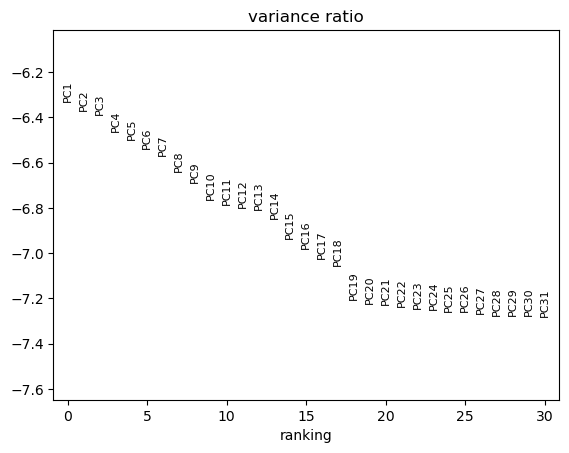

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


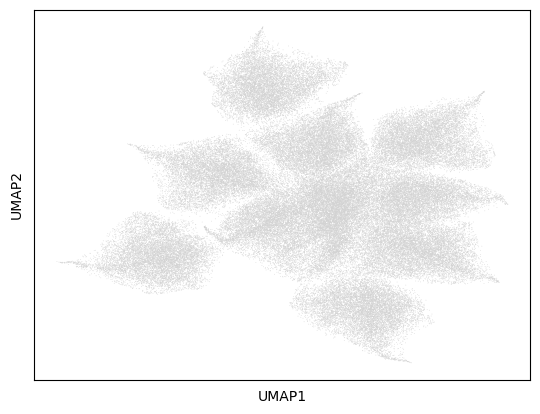

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


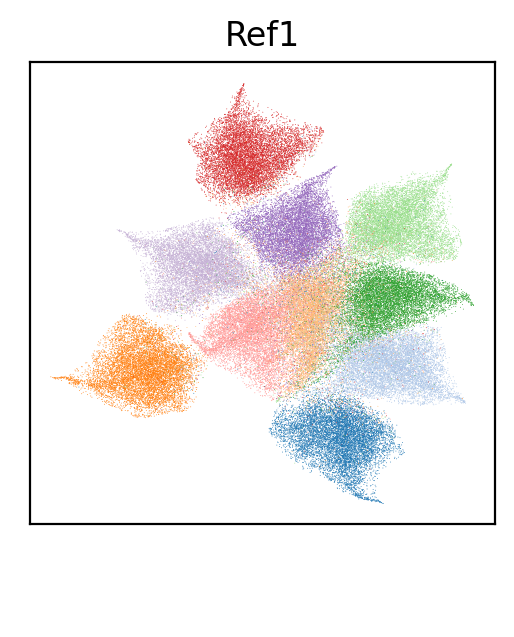

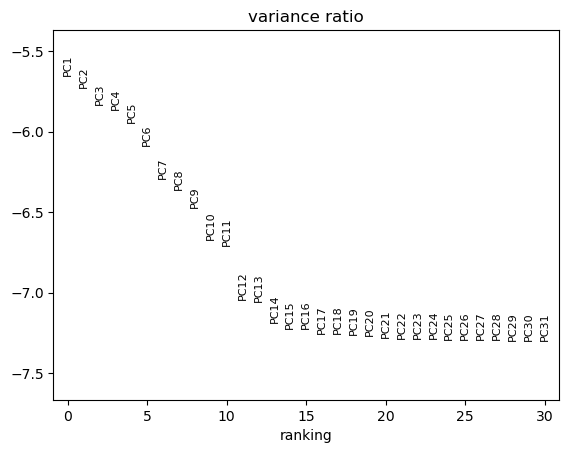

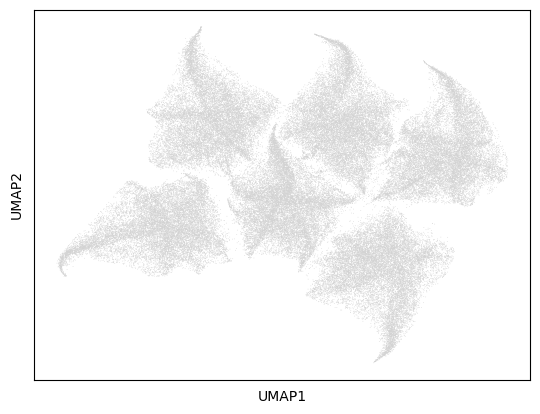

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


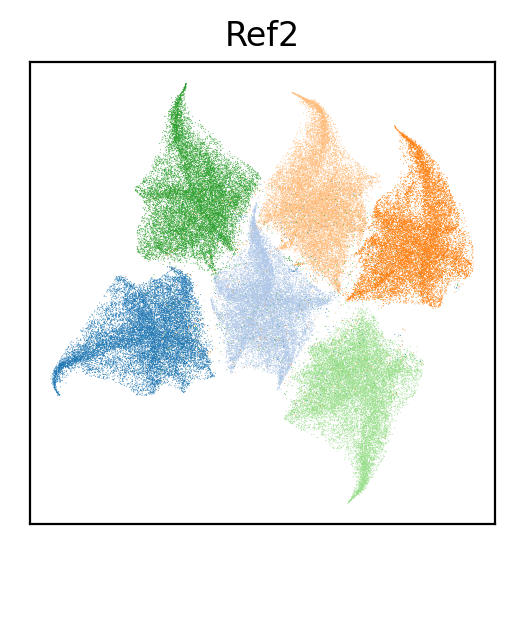

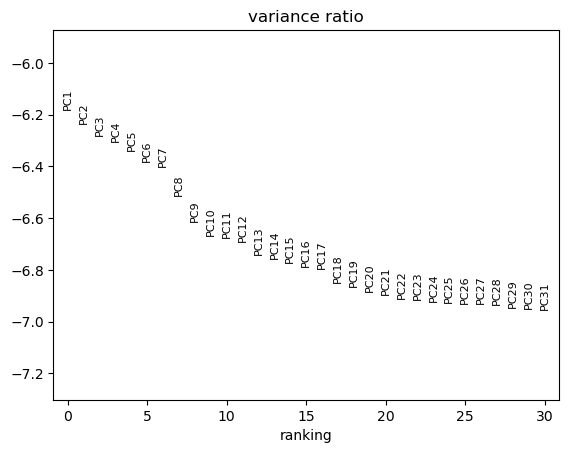

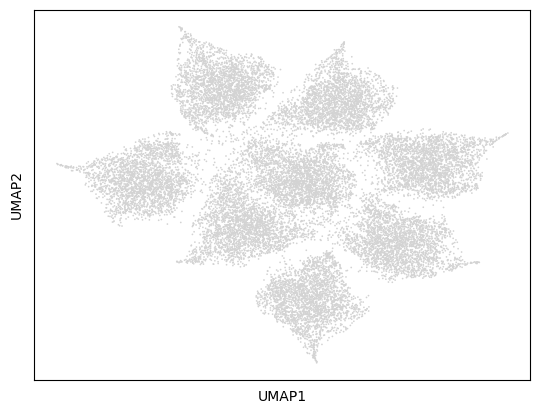

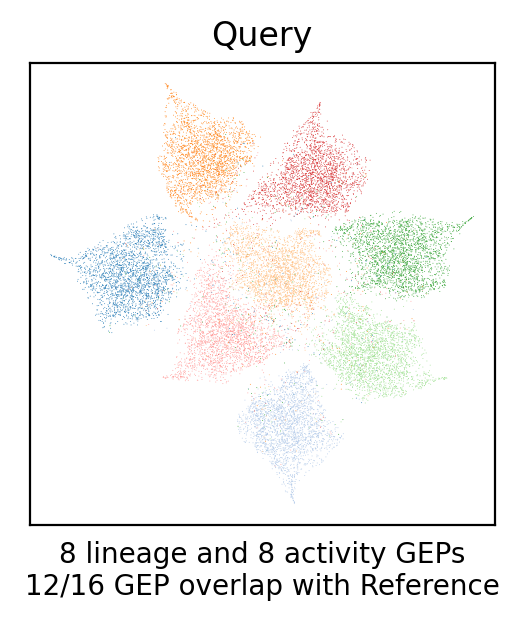

In [32]:
adatas = []
umaps = []
identity_map = dict(zip(np.arange(1,21), sns.color_palette("tab20")))
strmap = {'Ref1':'\n\n', 'Ref2':'\n\n', 'Query':'8 lineage and 8 activity GEPs\n12/16 GEP overlap with Reference'}
for (data, label) in [(simmod_ref1, 'Ref1'), (simmod_ref2, 'Ref2'), (simmod_query, 'Query')]:
    a = sc.AnnData(X=data.counts, obs=data.usage, var=data.geneparams)
    a = process(a)
    adatas.append(a)

    umap = pd.DataFrame(a.obsm['X_umap'], index=a.obs.index, columns=['U1', 'U2'])
    umap['identity'] = data.cellparams['Identity']
    umap['color'] = umap['identity'].apply(lambda x: identity_map[x])
    umaps.append(umap)

    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
    ax.scatter(umap['U1'], umap['U2'], c=umap['color'], s=.1, edgecolor='None')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label)
    
    ax.text(.5,-0.1,strmap[label], ha='center', va='center', transform=ax.transAxes)

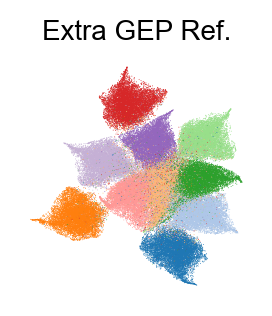

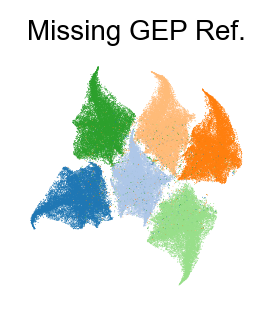

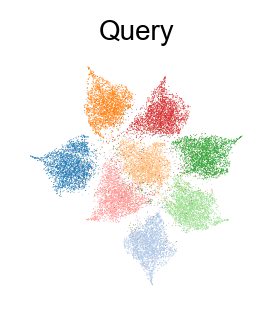

In [105]:
labels = ['Extra GEP Ref.', 'Missing GEP Ref.', 'Query']
name = ['ExtraGepRef', 'MissingGepRef', 'QueryData']
for i in range(3):
    umap = umaps[i]

    (fig,ax) = plt.subplots(1,1, figsize=(1.5,1.5), dpi=200, gridspec_kw={'top':.8, 'bottom':0})
    ax.scatter(umap['U1'], umap['U2'], c=umap['color'], s=.1, edgecolor='None', rasterized=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=10)
    ax.axis('off')
    
    #ax.text(.5,-0.1,strmap[label], ha='center', va='center', transform=ax.transAxes)
    fn = os.path.join(figdir, 'Simulation_UMAP_%s.png' % name[i])
    plt.savefig(fn)
    fn = os.path.join(figdir, 'Simulation_UMAP_%s.pdf' % name[i])
    plt.savefig(fn)

### Run cNMF for each dataset

In [10]:
def get_assignment(true_usages, inferred_usages):
    '''Get a mapping to reorder columns of inferred usage matrix
    to best match the columns of true usage matrix to allow easier comparison'''
    R = {}
    mapping = {}
    avail = set(true_usages.columns) # Set of programs to match
    toassign = set(inferred_usages.columns) #Set of programs to assign

    for i in inferred_usages.columns:
        R[i] = true_usages.corrwith(inferred_usages[i])
    
    R = pd.DataFrame.from_dict(R)
    Runst = R.unstack().reset_index()
    Runst.columns = ['learned', 'truth', 'corr']
    Runst = Runst.sort_values(by='corr', ascending=False)
    
    for i in Runst.index:
        if (Runst.loc[i, 'truth'] in avail) and (Runst.loc[i, 'learned'] in toassign):
            mapping[Runst.loc[i, 'learned']] = Runst.loc[i, 'truth']
            avail = avail - set([Runst.loc[i, 'truth']])
            toassign = toassign - set([Runst.loc[i, 'learned']])      
        
    
        if len(toassign) == 0:
            break
            
    return(mapping, R)


def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

def load_and_relabel(cobj, true_gep_means, K=11, ldthresh=0.07):
    res = {}
    hvgs = open(cobj.paths['nmf_genes_list']).read().split('\n')
    gene_scores_fn = cobj.paths['gene_spectra_tpm__txt'] % (K, str(ldthresh).replace('.','_'))
    gene_scores_Z_fn = cobj.paths['gene_spectra_score__txt'] % (K, str(ldthresh).replace('.','_'))
    
    gene_scores = pd.read_csv(gene_scores_fn, sep='\t', index_col=0)
    gene_scores = gene_scores.div(gene_scores.sum(axis=1), axis=0) * 1e6
    gene_scores_Z = pd.read_csv(gene_scores_Z_fn, sep='\t', index_col=0)

    
    stds = load_df_from_npz(cobj.paths['tpm_stats'])['__std']
    true_gep_means_hvgs = true_gep_means.loc[:, hvgs]
    gene_scores_hvgs = gene_scores.loc[:, hvgs]
    true_gep_means_hvgs_norm = true_gep_means_hvgs.div(stds.loc[hvgs], axis=1)    
    
    gene_scores_hvgs_norm = gene_scores_hvgs.div(stds.loc[hvgs], axis=1)
    assignmap, R = get_assignment(true_gep_means_hvgs_norm.T,
                                  gene_scores_hvgs_norm.T)
    
    fig,ax = plt.subplots(1,1, figsize=(3,3), dpi=200)
    gene_scores_hvgs_norm_relabeled = gene_scores_hvgs_norm.rename(index=assignmap)
    #gene_scores_hvgs_norm_relabeled.index = [int(x.replace('True_', '')) for x in gene_scores_hvgs_norm_relabeled.index]
    gene_scores_hvgs_norm_relabeled = gene_scores_hvgs_norm_relabeled.sort_index(axis=0)       
    
    R = df_col_corr(true_gep_means_hvgs_norm.T, gene_scores_hvgs_norm_relabeled.T)
    ax = sns.heatmap(R.sort_index(axis=1).sort_index(axis=0), xticklabels=True, yticklabels=True)
    ax.set_title('Spectra correlation')
    
    gene_scores_relabeled = gene_scores.rename(index=assignmap)
    gene_scores_relabeled = gene_scores_relabeled.sort_index(axis=0)   

    gene_scores_Z_relabeled = gene_scores_Z.rename(index=assignmap)
    gene_scores_Z_relabeled = gene_scores_Z_relabeled.sort_index(axis=0)     
    
    
    usage_fn = cobj.paths['consensus_usages__txt'] % (K, str(ldthresh).replace('.','_'))
    usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
    usage = usage.div(usage.sum(axis=1), axis=0)
    usage.columns = [int(x) for x in usage.columns]
    usage_relabeled = usage.rename(columns=assignmap)
    #usage_relabeled.columns = [int(x.replace('True_', '')) for x in usage_relabeled.columns]
    usage_relabeled = usage_relabeled.sort_index(axis=1)   
    #usage_relabeled.columns = ['cNMF_%d' % x for x in usage_relabeled.columns]    

    res = {'stds':stds, 'hvgs':hvgs, 'usage':usage_relabeled, 'tpm':gene_scores_relabeled, 'Z':gene_scores_Z_relabeled}
    return(res)

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=20.


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=12.


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=16.


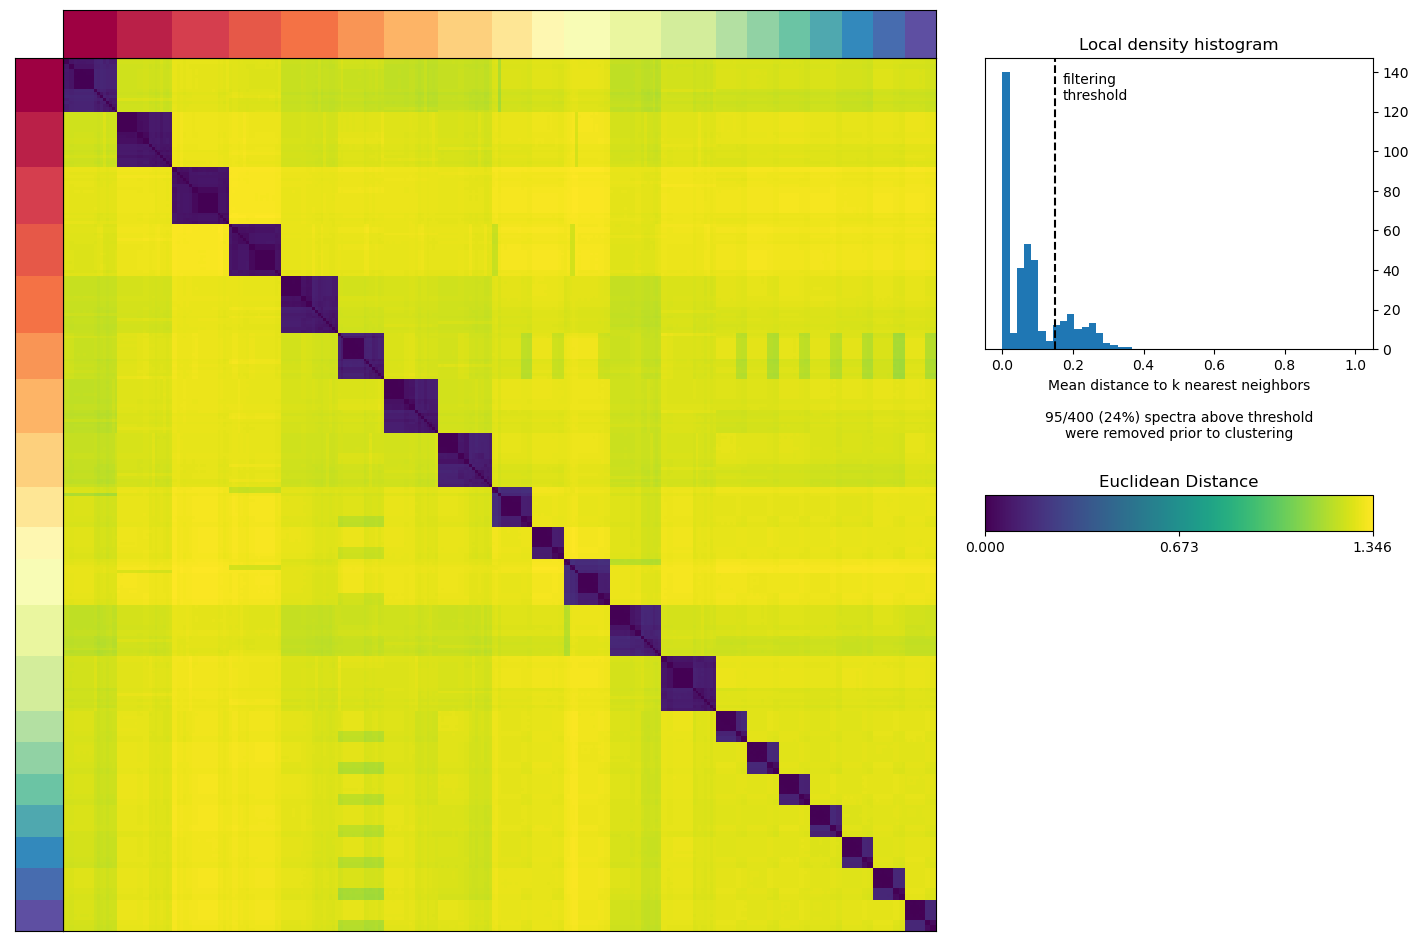

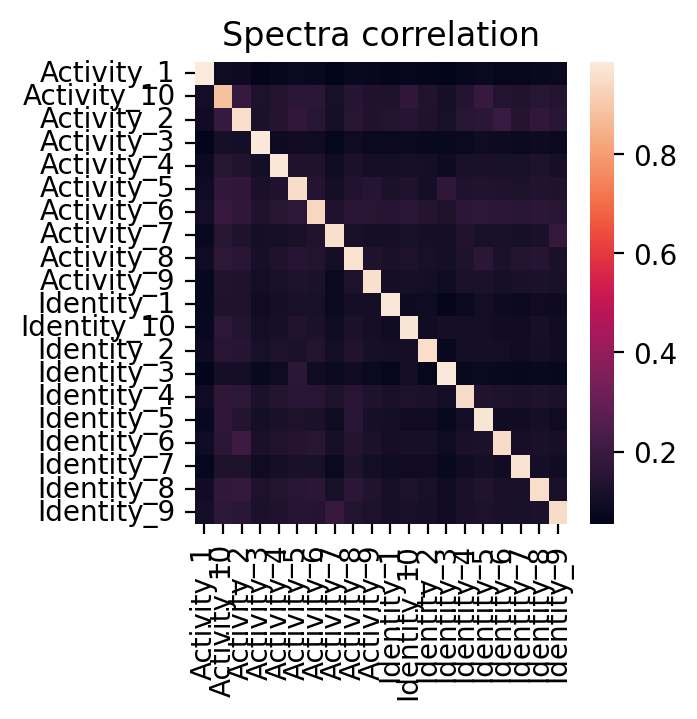

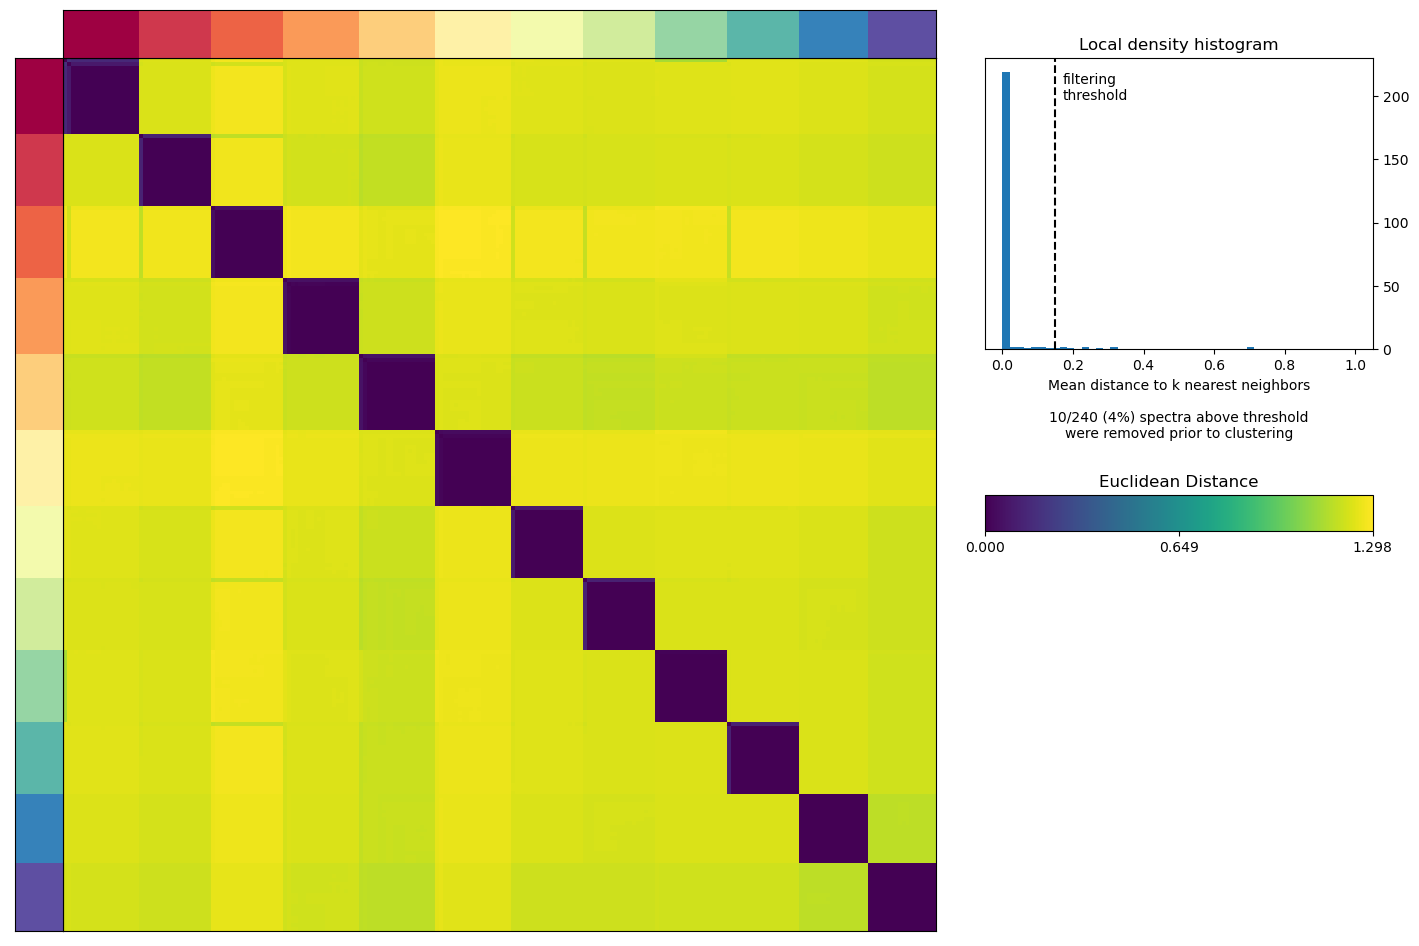

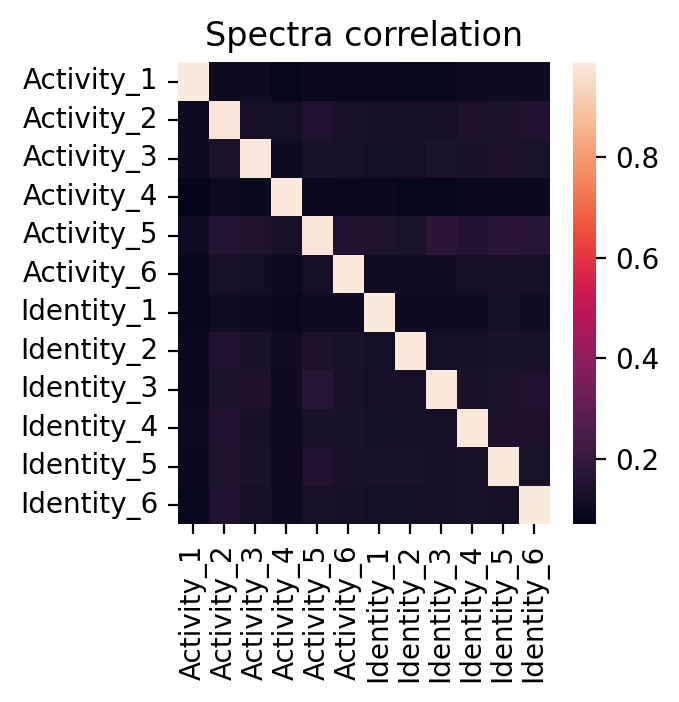

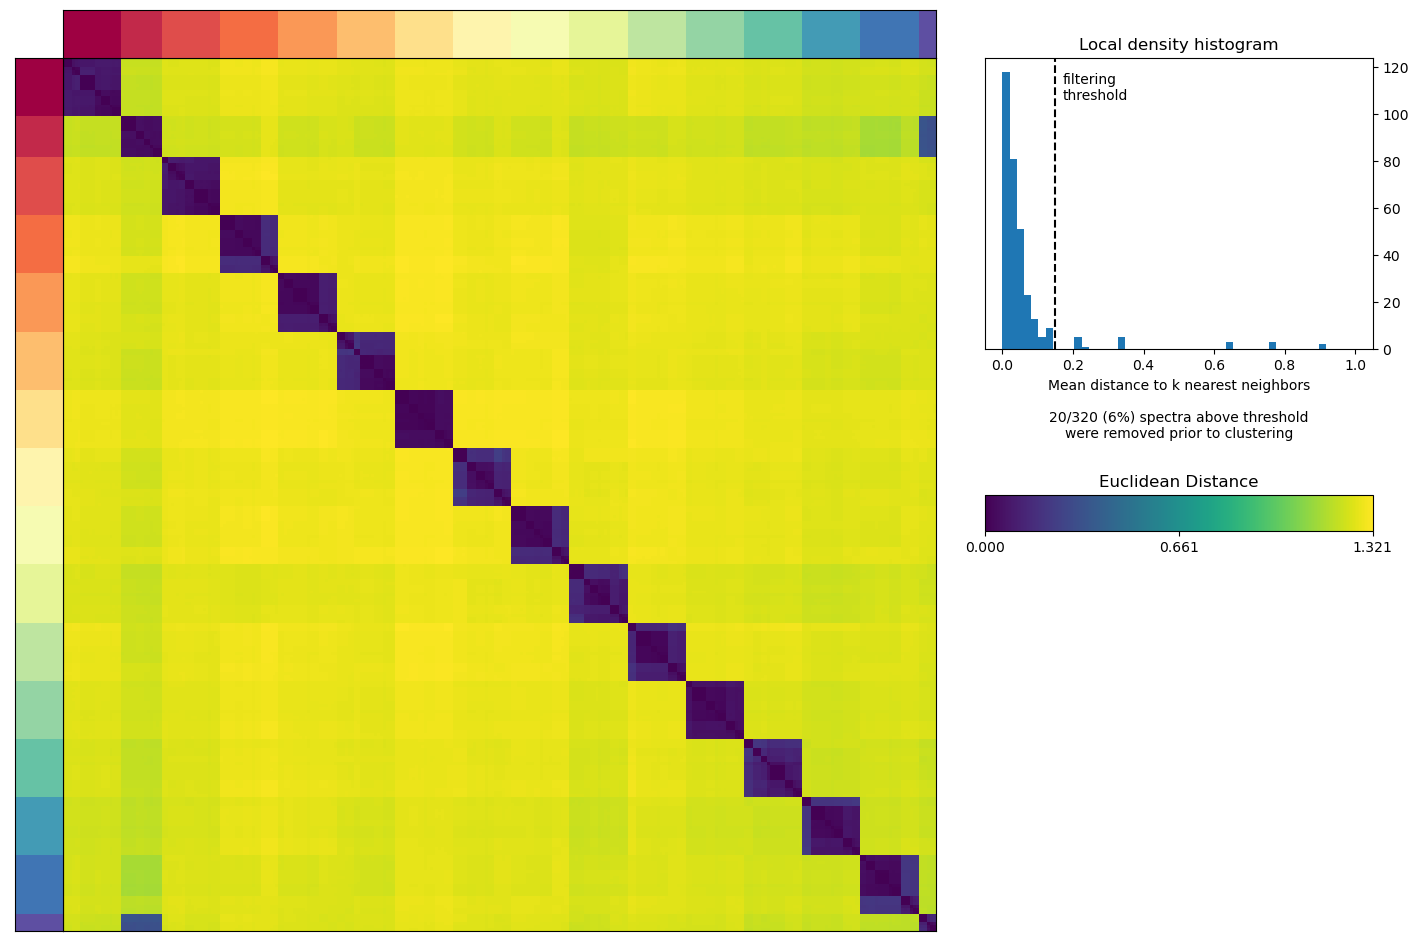

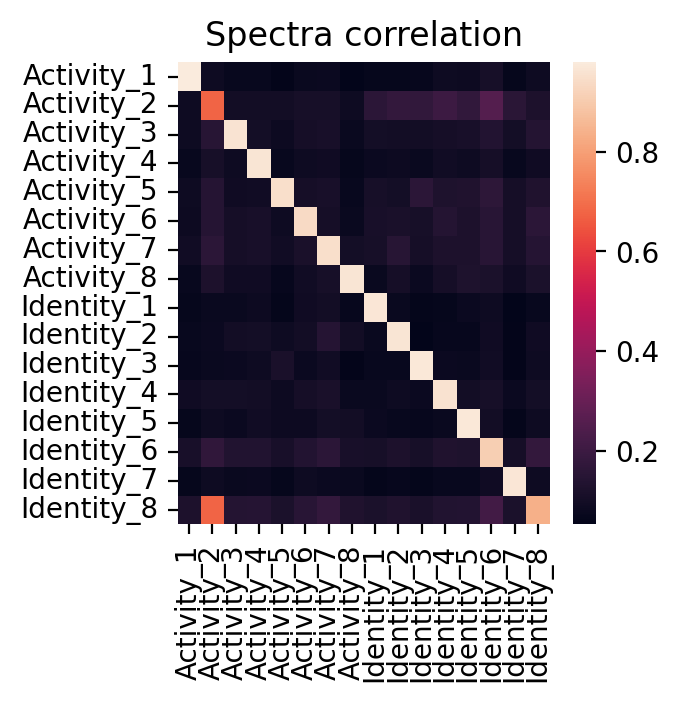

In [65]:
kmap = {'Ref1':20, 'Ref2':12, 'Query':16}
threshmap = {'Ref1':.15, 'Ref2':.15, 'Query':.15}
all_results = {}
for (data, label) in [(simmod_ref1, 'Ref1'),  (simmod_ref2, 'Ref2'), (simmod_query, 'Query')]:
    a = sc.AnnData(X=data.counts, obs=data.usage, var=data.spectra.T).copy()
    sc.pp.filter_genes(a, min_cells=5)
    countfn = '{d}/{lab}.counts.h5ad'.format(d=datadir, lab=label)
    sc.write(countfn, a)
    data.geneparams.to_csv('{d}/{lab}.geneparams.tsv'.format(d=datadir, lab=label), sep='\t')
    cnmf_obj = cNMF(output_dir=datadir, name=label)
    cnmf_obj.prepare(counts_fn=countfn, components=kmap[label], n_iter=20, seed=14, num_highvar_genes=1000)
    cnmf_obj.factorize()
    cnmf_obj.combine()
    cnmf_obj.consensus(k=kmap[label], local_neighborhood_size=0.3,
                       density_threshold=threshmap[label], show_clustering=True, refit_usage=True)
    
    X = pd.DataFrame(a.X, index=a.obs.index, columns=a.var.index)
    res = load_and_relabel(cnmf_obj, data.spectra, K=kmap[label], ldthresh=threshmap[label])
    all_results[label] = res

In [9]:
all_results_fn = '{d}/cNMF_Results_QueryAndRefs.pkl'.format(d=datadir)
all_results_fn

'../../../Data/PerDataset/TCAT_Simulation/Deloc1.5_new/cNMF_Results_QueryAndRefs.pkl'

In [18]:
with open(all_results_fn, 'wb') as handle:
    pickle.dump(all_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open(all_results_fn, 'rb') as handle:
    all_results = pickle.load(handle)

### Confirm relabeling worked

## Illustrate TCAT 

In [8]:
simmod_adata = sc.AnnData(X=simmod_query.counts, obs=simmod_query.usage, var=simmod_query.spectra.T).copy()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [11]:
r = 'Ref1'
ref = all_results[r]['tpm'].copy()
ref = ref.loc[:, all_results[r]['hvgs']]
ref = ref.div(all_results[r]['stds'][ref.columns], axis=1)

In [12]:
tmod = starcat(alpha=0, l1_ratio=0, tpm_norm=False, var_norm=True, copy=True)
rf_usage = tmod.fit_transform(simmod_adata, ref_spectra=ref)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

909 out of 1000 genes in the reference overlap with the query


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
rf_usage_norm.head()

Activity_1  Activity_10  Activity_2  Activity_3  Activity_4  \
Cell_1    0.369024     0.025193    0.025445    0.014320    0.006130   
Cell_2    0.116979     0.052082    0.031408    0.010331    0.046534   
Cell_3    0.000889     0.008203    0.001528    0.058913    0.166872   
Cell_4    0.000942     0.229440    0.060060    0.064415    0.016141   
Cell_5    0.000341     0.043113    0.002292    0.019563    0.090107   

        Activity_5  Activity_6  Activity_7  Activity_8  Activity_9  \
Cell_1    0.008568    0.106271    0.028945    0.012779    0.038480   
Cell_2    0.111071    0.049380    0.049094    0.025999    0.010845   
Cell_3    0.091162    0.054279    0.081672    0.125032    0.019848   
Cell_4    0.064154    0.007043    0.213844    0.004613    0.000080   
Cell_5    0.000345    0.005575    0.026197    0.011169    0.090757   

        Identity_1  Identity_10  Identity_2  Identity_3  Identity_4  \
Cell_1    0.009544     0.006529    0.012167    0.054063    0.036547   
Cell_2    0.012028     0.022551    0.046309    0.000530    0.140796   
Cell_3    0.003369     0.011839    0.000050    0.000845    0.004531   
Cell_4    0.002261     0.086905    0.002447    0.040337    0.003198   
Cell_5    0.007184     0.010806    0.088459    0.006017    0.008872   

        Identity_5  Identity_6  Identity_7  Identity_8  Identity_9  
Cell_1    0.026012    0.162105    0.023542    0.000867    0.033470  
Cell_2    0.039350    0.067433    0.015351    0.001674    0.150256  
Cell_3    0.114727    0.003409    0.036283    0.000289    0.216260  
Cell_4    0.010829    0.008187    0.115278    0.042325    0.027501  
Cell_5    0.471801    0.055987    0.009097    0.041644    0.010674

In [14]:
tcatorder = ['Identity_%d' % n for n in range(9, 11)]  + ['Activity_%d' % n for n in range(9,11)] 
tcatorder += ['Identity_%d' % n for n in range(1,9)]  + ['Activity_%d' % n for n in range(1,9)] 

Text(52.315972222222214, 0.5, 'TCAT Fit Usage')

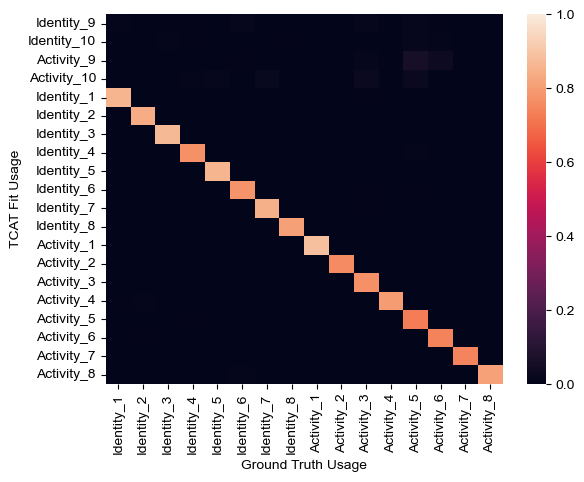

In [84]:
R_tcat_extra = df_col_corr(rf_usage_norm[tcatorder], simmod_query.usage)
ax = sns.heatmap(R_tcat_extra, vmin=0, vmax=1)
ax.set_xlabel('Ground Truth Usage')
ax.set_ylabel('TCAT Fit Usage')

In [16]:
r = 'Ref2'
ref = all_results[r]['tpm'].copy()
ref = ref.loc[:, all_results[r]['hvgs']]
ref = ref.div(all_results[r]['stds'][ref.columns], axis=1)

In [17]:
tmod = starcat(alpha=0, l1_ratio=0, tpm_norm=False, var_norm=True, copy=True)
rf_usage = tmod.fit_transform(simmod_adata, ref_spectra=ref)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

908 out of 1000 genes in the reference overlap with the query


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
rf_usage_norm.shape

(20000, 12)

In [19]:
tcatorder = ['Identity_%d' % n for n in range(1,7)]  + ['Activity_%d' % n for n in range(1,7)] 
usageorder = ['Identity_%d' % n for n in range(1,7)]  + ['Activity_%d' % n for n in range(1,7)] 
usageorder += ['Identity_%d' % n for n in range(7,9)]  + ['Activity_%d' % n for n in range(7,9)] 

Text(52.315972222222214, 0.5, 'TCAT Fit Usage')

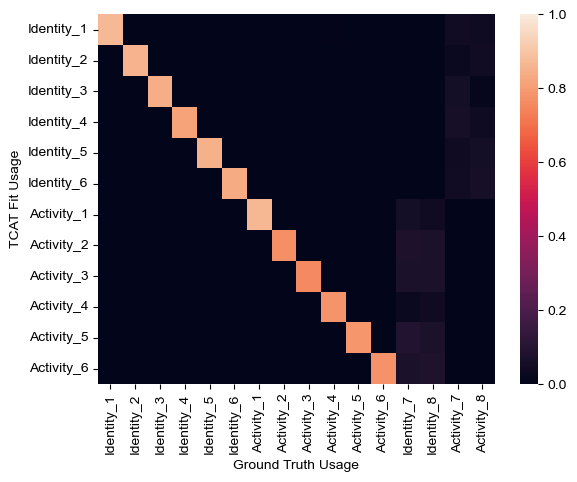

In [89]:
R_tcat_short = df_col_corr(rf_usage_norm[tcatorder], simmod_query.usage[usageorder])
ax = sns.heatmap(R_tcat_short, vmin=0, vmax=1)
ax.set_xlabel('Ground Truth Usage')
ax.set_ylabel('TCAT Fit Usage')

In [21]:
usageorder = ['Identity_%d' % n for n in range(1,9)]  + ['Activity_%d' % n for n in range(1,9)] 
R_cnmf = df_col_corr(all_results['Query']['usage'][usageorder], simmod_query.usage[usageorder])

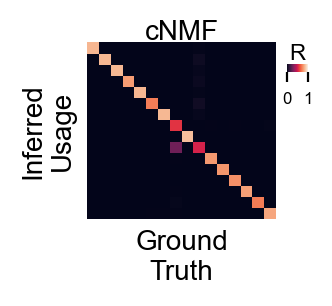

In [94]:
fig = plt.figure(figsize=(1.4, 1.4), dpi=200)

# Define the gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[0.1,0.9], height_ratios=[0.1,0.9],
                       wspace=0, hspace=0, bottom=.15, left=.15, right=.9, top=.85)

# Create four axes based on the gridspec
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

cax = ax1.inset_axes([10.5, -1.5, 1, 0.4], transform=ax1.transAxes)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax = sns.heatmap(R_cnmf, vmin=0, vmax=1, ax=ax4, cbar_ax=cax, cbar_kws={'orientation':'horizontal'})
ax.set_yticks([])
ax.set_xticks([])
ax4.set_xlabel('Ground\nTruth', fontsize=10)
ax4.set_ylabel('Inferred\nUsage', fontsize=10)
ax2.text(0.5, .5, 'cNMF', ha='center', va='center')
cax.set_title('R', fontsize=8, pad=-1)
cax.tick_params(labelsize=6)


plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_cNMF.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_cNMF.pdf'), bbox_inches="tight")

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


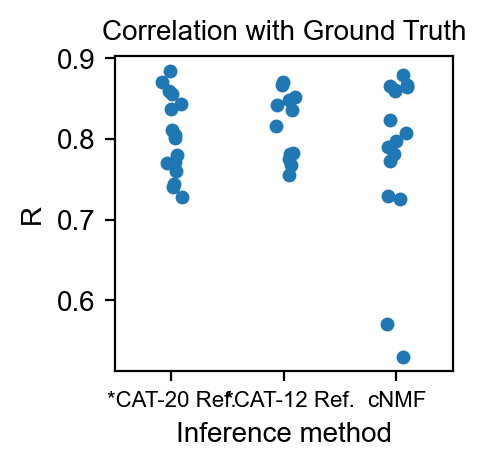

In [161]:
combined = pd.DataFrame(R_tcat_extra.iloc[4:,:].values[np.diag_indices(16)])
combined['Source'] = 'Extra GEP Reference'

r2 = pd.DataFrame(R_tcat_short.iloc[:,:-4].values[np.diag_indices(12)])
r2['Source'] = 'Deficient GEP Reference'


c2 = pd.DataFrame(R_cnmf.values[np.diag_indices(16)])
c2['Source'] = 'cNMF'

combined = pd.concat([combined, r2, c2], axis=0)
combined.columns = ['R', 'Source']

#(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200, gridspec_kw={'left':.2, 'bottom':.2})

fig = plt.figure(figsize=(2.5, 2.5), dpi=200)

# Define the gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[0.1,0.9], height_ratios=[0.1,0.9],
                       wspace=0, hspace=0, bottom=.15, left=.15, right=.9, top=.85)

# Create four axes based on the gridspec
#ax1 = fig.add_subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[0, 1])
#ax3 = fig.add_subplot(gs[1, 0])
ax = fig.add_subplot(gs[1, 1])





sns.stripplot(x='Source', y='R', data=combined, ax=ax)
ax.set_ylabel('R', fontsize=10)
ax.set_xlabel('Inference method', fontsize=10)

ax.set_title('Correlation with Ground Truth', fontsize=10)
ax.set_xticklabels(['*CAT-20 Ref.', '  *CAT-12 Ref.', 'cNMF'], fontsize=8)

plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_ComparisonStripPlot.png'))
plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_ComparisonStripPlot.pdf'))

In [146]:
combined.loc[combined['Source']=='Extra GEP Reference', 'R'].min(), combined.loc[combined['Source']=='Extra GEP Reference', 'R'].mean()

(0.7287342264133988, 0.8040613357026574)

In [147]:
combined.loc[combined['Source']=='Deficient GEP Reference', 'R'].min(), combined.loc[combined['Source']=='Deficient GEP Reference', 'R'].mean()

(0.7554676361598422, 0.8162030763306639)

In [149]:
combined.loc[combined['Source']=='cNMF', 'R'].min(), combined.loc[combined['Source']=='cNMF', 'R'].mean()

(0.5296984088051485, 0.7828404020042521)

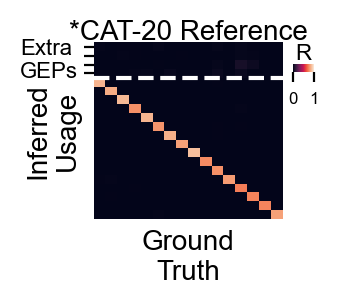

In [95]:

fig = plt.figure(figsize=(1.4, 1.4), dpi=200)

# Define the gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[0.1,0.9], height_ratios=[0.1,0.9],
                       wspace=0, hspace=0, bottom=.15, left=.15, right=.9, top=.85)

# Create four axes based on the gridspec
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

cax = ax1.inset_axes([10.5, -1.5, 1, 0.4], transform=ax1.transAxes)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')


#ax1.text(0, .85, 'Not in\nquery', fontsize=8)
#ax4.text(.0, .5, 'Not in\nref.', fontsize=8)


cax.tick_params(labelsize=6)

ax = sns.heatmap(R_tcat_extra, vmin=0, vmax=1, ax=ax4, cbar_ax=cax, cbar_kws={'orientation':'horizontal'})



ax4.set_xlabel('Ground\nTruth', fontsize=10)
ax4.set_ylabel('Inferred\nUsage', labelpad = -2.5, fontsize=10)
ax.set_yticks([])
ax.set_xticks([])


ax.hlines(y=4, xmin=0, xmax=20, linestyle='--', color='w')
#ax.vlines(x=2, ymin=0, ymax=20, linestyle='--', color='w')

ax.set_yticks(np.array([1,2, 3, 4])-.5)
ax.set_yticklabels(['']*4)
#ax.set_xticks(np.array([1,2,3,4])-.5)
#ax.set_xticklabels(['']*4)

ax3.text(-2.5, .9, 'Extra\nGEPs', fontsize=8, va='center')
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])

ax2.text(0.5, 0.5, '*CAT-20 Reference', ha='center', va='center')
cax.set_title('R', fontsize=8, pad=-1)


plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_ExtraGepRef.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_ExtraGepRef.pdf'), bbox_inches="tight")

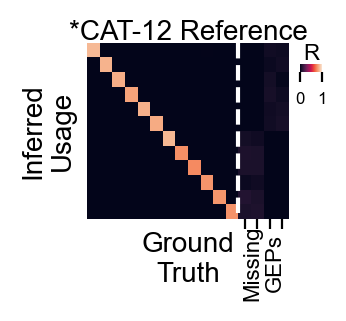

In [96]:

fig = plt.figure(figsize=(1.4, 1.4), dpi=200)

# Define the gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[0.1,0.9], height_ratios=[0.1,0.9],
                       wspace=0, hspace=0, bottom=.15, left=.1, right=.9, top=.85)

# Create four axes based on the gridspec
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

cax = ax1.inset_axes([10.5, -1.5, 1, 0.4], transform=ax1.transAxes)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')


#ax1.text(0, .85, 'Not in\nquery', fontsize=8)
#ax4.text(.0, .5, 'Not in\nref.', fontsize=8)


cax.tick_params(labelsize=6)

ax = sns.heatmap(R_tcat_short, vmin=0, vmax=1, ax=ax4, cbar_ax=cax, cbar_kws={'orientation':'horizontal'})



ax4.set_xlabel('Ground\nTruth', labelpad= -2.5, fontsize=10)
ax4.set_ylabel('Inferred\nUsage', fontsize=10)
ax.set_yticks([])
ax.set_xticks([])


ax.vlines(x=12, ymin=0, ymax=20, linestyle='--', color='w')
#ax.vlines(x=2, ymin=0, ymax=20, linestyle='--', color='w')

ax.set_xticks(np.array([13,14, 15, 16])-.5)
ax.set_xticklabels(['']*4)
#ax.set_xticks(np.array([1,2,3,4])-.5)
#ax.set_xticklabels(['']*4)

# ax4.text(14.5, 14, 'Missing\nGEPs', fontsize=8, va='center', ha='center')
ax4.text(14, 15, 'Missing\nGEPs', fontsize=8, va='center', ha='center', rotation = 90)

ax2.set_xlim([0,1])
ax2.set_ylim([0,1])

ax2.text(0.5, 0.5, '*CAT-12 Reference', ha='center', va='center')
cax.set_title('R', fontsize=8, pad=-1)


plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_MissingGepRef.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Simulation_UsageCorr_MissingGepRef.pdf'), bbox_inches="tight")

# Perform comparison while varying query size

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=16.
908 out of 1000 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


884 out of 1000 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


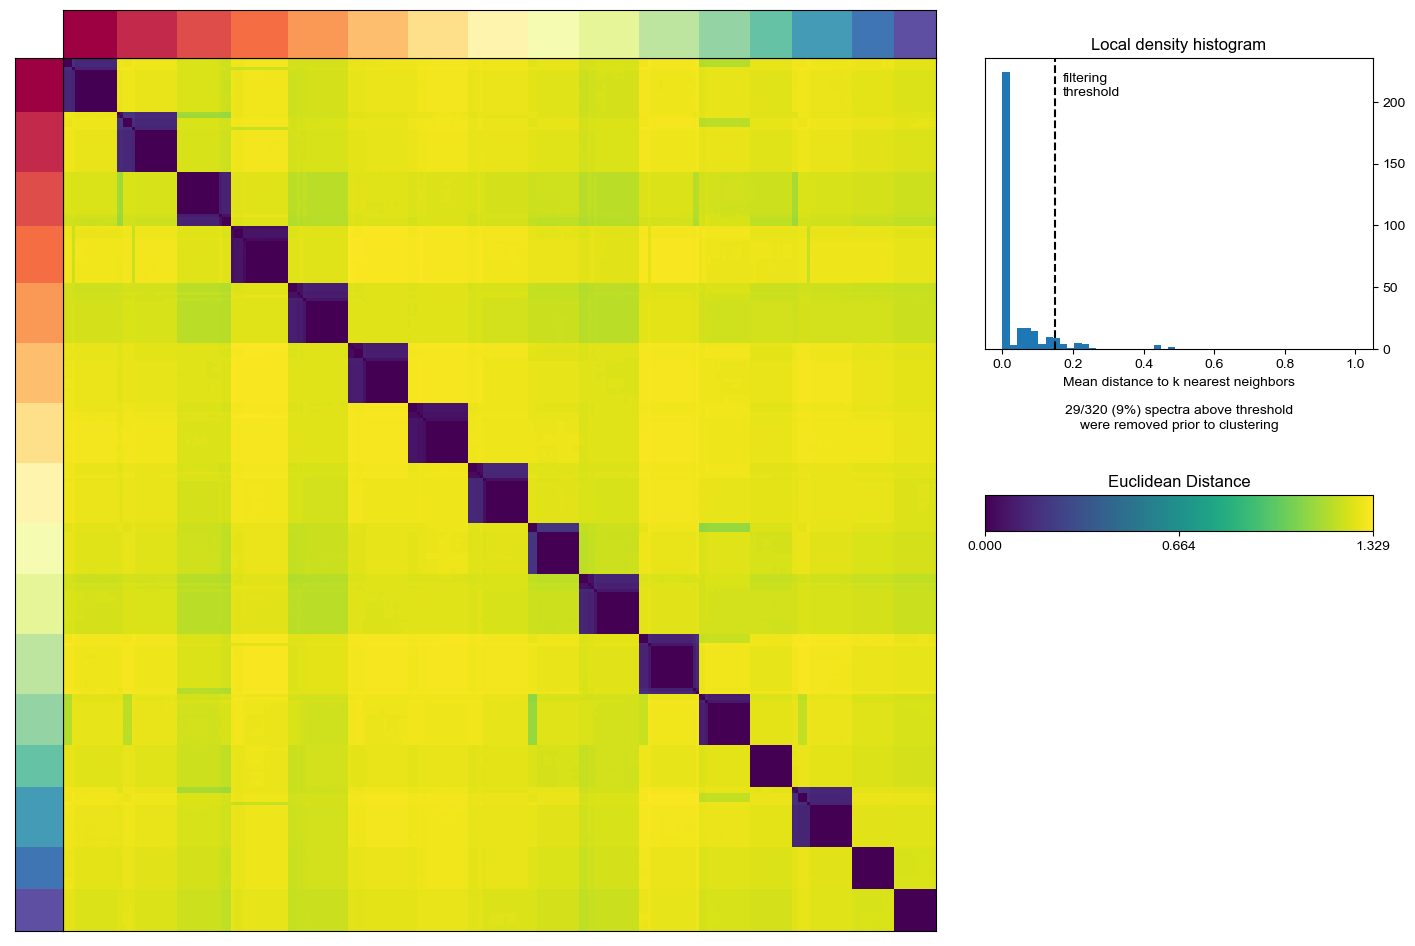

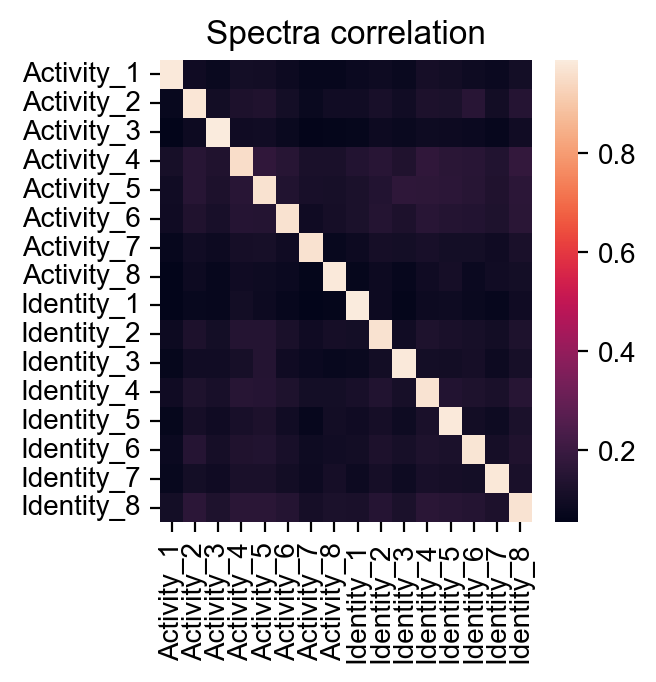

In [11]:
def run_cnmf(outdir, label, countfn, K, ldthresh, true_spectra):
    cnmf_obj = cNMF(output_dir=outdir, name=label)
    cnmf_obj.prepare(counts_fn=countfn, components=K, n_iter=20, seed=14, num_highvar_genes=1000)
    cnmf_obj.factorize()
    cnmf_obj.combine()
    cnmf_obj.consensus(k=K, local_neighborhood_size=0.3,
                       density_threshold=ldthresh, show_clustering=True, refit_usage=True)
    
    res = load_and_relabel(cnmf_obj, true_spectra, K=K, ldthresh=ldthresh)
    return(res)

ncells = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]
cnmf_usageorder = ['Identity_%d' % n for n in range(1,9)]  + ['Activity_%d' % n for n in range(1,9)] 
ref2order = ['Identity_%d' % n for n in range(1,7)]  + ['Activity_%d' % n for n in range(1,7)] 

K = 16

res_allKs = []

for ncell in ncells:
    label = 'Query%d' % ncell
    outdir = os.path.join(datadir, label)
    query_pkl_fn = '{d}/query_{n}cell.pkl'.format(d=outdir, n=ncell)        
    with open(query_pkl_fn, 'rb') as handle:
        query = pickle.load(handle)
    
    a = sc.AnnData(X=query.counts, obs=query.usage, var=query.spectra.T).copy()
    sc.pp.filter_genes(a, min_cells=5)
    
    ## cNMF step 
    countfn = '{d}/{lab}.counts.h5ad'.format(d=outdir, lab=label)
    sc.write(countfn, a)
    a.var.to_csv('{d}/{lab}.geneparams.tsv'.format(d=datadir, lab=label), sep='\t')
    
    res = run_cnmf(outdir, label, countfn, K, 0.15, query.spectra)
    R_cnmf = df_col_corr(res['usage'][cnmf_usageorder], query.usage[cnmf_usageorder])
    c = pd.DataFrame(R_cnmf.values[np.diag_indices(K)])
    c.columns = ['R']
    c['N'] = ncell
    c['Method'] = 'cNMF'    
    
    ## TCAT REF1
    r = 'Ref1'
    ref = all_results[r]['tpm'].copy()
    ref = ref.loc[:, all_results[r]['hvgs']]
    ref = ref.div(all_results[r]['stds'][ref.columns], axis=1)
    tmod = starcat(alpha=0, l1_ratio=0, tpm_norm=False, var_norm=True, copy=True)
    rf_usage = tmod.fit_transform(a, ref_spectra=ref)
    rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)
    R_tcat1 = df_col_corr(rf_usage_norm[cnmf_usageorder], query.usage[cnmf_usageorder])
    c2 = pd.DataFrame(R_tcat1.values[np.diag_indices(len(cnmf_usageorder))])
    c2.columns = ['R']
    c2['N'] = ncell
    c2['Method'] = 'TCAT 20GEP Ref'

    
    ## TCAT REF2
    r = 'Ref2'
    ref = all_results[r]['tpm'].copy()
    ref = ref.loc[:, all_results[r]['hvgs']]
    ref = ref.div(all_results[r]['stds'][ref.columns], axis=1)
    tmod = starcat(alpha=0, l1_ratio=0, tpm_norm=False, var_norm=True, copy=True)
    rf_usage = tmod.fit_transform(a, ref_spectra=ref)
    rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)
    R_tcat2 = df_col_corr(rf_usage_norm[ref2order], query.usage[ref2order])
    c3 = pd.DataFrame(R_tcat2.values[np.diag_indices(len(ref2order))])
    c3.columns = ['R']
    c3['N'] = ncell
    c3['Method'] = 'TCAT 12GEP Ref'
    
    res_allKs += [c, c2, c3]

In [120]:
res_allKs_merged = pd.concat(res_allKs, axis=0)

In [18]:
allk_results_fn = '{d}/cNMF_andTCAT_Results_Rvalues_MultiK.tsv'.format(d=datadir)

In [19]:
res_allKs_merged.to_csv(allk_results_fn, sep='\t')

In [132]:
res_allKs_merged = pd.read_csv(allk_results_fn, sep='\t', index_col=0)
res_allKs_merged.index = np.arange(res_allKs_merged.shape[0])

In [133]:
res_allKs_merged.head()

R    N Method
0  0.220698  100   cNMF
1  0.370303  100   cNMF
2  0.410604  100   cNMF
3  0.062904  100   cNMF
4  0.491689  100   cNMF

In [134]:
res_allKs_merged['Method'] = res_allKs_merged['Method'].replace({'cNMF':'cNMF', 'TCAT 12GEP Ref':'*CAT-12', 'TCAT 20GEP Ref':'*CAT-20'})

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


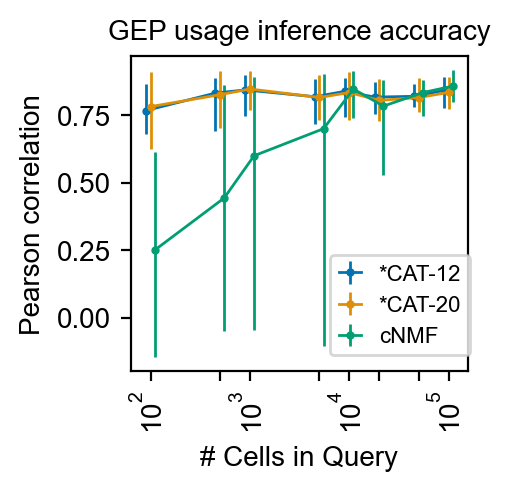

In [188]:

summary_df = res_allKs_merged.groupby(['N', 'Method']).agg(
    R_mean=('R', 'mean'),
    R_max=('R', lambda x: x.max()),
    R_min=('R', lambda x: x.min())
).reset_index()
summary_df['R_min'] = summary_df['R_mean'] - summary_df['R_min']
summary_df['R_max'] = summary_df['R_max'] - summary_df['R_mean']

summary_df['Nloc'] = summary_df['N']
ind = summary_df['Method'] == 'cNMF'
summary_df.loc[ind, 'Nloc'] = summary_df.loc[ind, 'N']*1.1
ind = summary_df['Method'] == '*CAT-12'
summary_df.loc[ind, 'Nloc'] = summary_df.loc[ind, 'N']*.9

# Plotting
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)

# Define the gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[0.1,0.9], height_ratios=[0.1,0.9],
                       wspace=0, hspace=0, bottom=.2, left=.15, right=.9, top=.9)
ax = fig.add_subplot(gs[1, 1])


colors = sns.color_palette("colorblind", 3)

for (method, color) in zip(summary_df['Method'].unique(), colors):
    subset = summary_df[summary_df['Method'] == method]
    #ax4.plot(subset['N']+xdelta[method], subset['R_mean'], label=method, color=color)
    
    ax.errorbar(subset['Nloc'], subset['R_mean'],
                 yerr=subset[['R_min', 'R_max']].T, fmt='-o',
                 label=method, color=color, markersize=2, lw=1)


ax.set_xlabel('# Cells in Query', fontsize=10)
ax.set_ylabel('Pearson correlation', fontsize=10)
ax.set_title( 'GEP usage inference accuracy', fontsize=10)

ax.legend(loc=(.59,.05), fontsize=8, handlelength=1.0)
ax.set_xticklabels(ax4.get_xticks(), rotation=90)
ax.set_xscale('log')
_ = ax.set_xticks(subset['N'].unique())

plt.savefig(os.path.join(figdir, 'Simulation_PearsonCorr_ByN.png'))
plt.savefig(os.path.join(figdir, 'Simulation_PearsonCorr_ByN.pdf'))

In [48]:
subset

N   Method    R_mean     R_max     R_min      Nloc
2      100  cNMF-16  0.250177  0.361313  0.394232     115.0
5      500  cNMF-16  0.442944  0.416865  0.490331     575.0
8     1000  cNMF-16  0.599298  0.292215  0.644264    1150.0
11    5000  cNMF-16  0.699293  0.201430  0.805040    5750.0
14   10000  cNMF-16  0.846064  0.068103  0.106583   11500.0
17   20000  cNMF-16  0.782840  0.096967  0.253140   23000.0
20   50000  cNMF-16  0.833047  0.048100  0.087887   57500.0
23  100000  cNMF-16  0.856850  0.058168  0.059116  115000.0

In [95]:
subset['R_mean']

0    0.766609
3    0.831109
6    0.842808
Name: R_mean, dtype: float64

In [96]:
subset[['R_min', 'R_max']]

R_min     R_max
0  0.086377  0.096330
3  0.141873  0.056239
6  0.097296  0.055354

In [97]:
subset['N']+xdelta[method]

0     115
3     515
6    1015
Name: N, dtype: int64

In [49]:
sorted(ref1order)

['Activity_1',
 'Activity_10',
 'Activity_2',
 'Activity_3',
 'Activity_4',
 'Activity_5',
 'Activity_6',
 'Activity_7',
 'Activity_8',
 'Activity_9',
 'Identity_1',
 'Identity_10',
 'Identity_2',
 'Identity_3',
 'Identity_4',
 'Identity_5',
 'Identity_6',
 'Identity_7',
 'Identity_8',
 'Identity_9']

In [52]:
sorted(query.usage.columns)

['Activity_1',
 'Activity_2',
 'Activity_3',
 'Activity_4',
 'Activity_5',
 'Activity_6',
 'Activity_7',
 'Activity_8',
 'Identity_1',
 'Identity_2',
 'Identity_3',
 'Identity_4',
 'Identity_5',
 'Identity_6',
 'Identity_7',
 'Identity_8']

# Simulation 2

In [3]:
datadir = '../../../Data/PerDataset/TCAT_Simulation/Deloc2.0'
if not os.path.exists(datadir): os.mkdir(datadir)

### Prepare catalog of GEPs

In [4]:
nidentity = 12
nactivity = 12
simmod_catalog = scsim2(seed=20, diffexploc=2.0)
simmod_catalog.simulate(ncells=10000, ngenes=10000, nidentities=nidentity, activity_pct=[.3]*nactivity,
                activity_min=[.1]*nactivity, activity_max=[.7]*nactivity,
                activity_identities=[list(range(1,nidentity+1))]*nactivity,
                pct_doublets=.05)

Simulating cells
Simulating gene params
Simulating DE
Simulating doublets
Simulating cell-gene means
Adjusting means
Simulating counts


In [5]:
simmod_catalog.counts.to_csv('{d}/refcatalog_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_catalog.usage.to_csv('{d}/refcatalog_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_catalog.spectra.to_csv('{d}/refcatalog_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_catalog.geneparams.to_csv('{d}/refcatalog_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_catalog.cellparams.to_csv('{d}/refcatalog_cellparams.tsv'.format(d=datadir), sep='\t')

In [6]:
catalog_pkl_fn = '{d}/gep_catalog.pkl'.format(d=datadir)

In [7]:
with open(catalog_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_catalog, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Prepare reference 1

In [8]:
simmod_ref1 = scsim2(seed=14, diffexploc=2.0)

nrefidentity = nidentity
nrefactivity = nactivity

thisdata = simmod_ref1
thisdata.cellparams, thisdata.usage = thisdata.get_usages(ncells=50000,
                                               nidentities=nrefidentity, activity_pct=[.3]*nrefactivity,
                                               activity_min=[.1]*nrefactivity, activity_max=[.7]*nrefactivity,
                                               activity_identities=[list(range(1,nidentity+1))]*nrefactivity,
                                               max_activity_total=.7)

ngenes = 9000
overlap = np.random.choice(simmod_catalog.geneparams.index, size=ngenes, replace=False)

thisdata.geneparams = simmod_catalog.geneparams.loc[simmod_catalog.geneparams.index.isin(overlap), :]
tokeep = [x for x in thisdata.geneparams if x in ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean'] or (x.split('.')[0] in thisdata.usage.columns)]
thisdata.geneparams = thisdata.geneparams.loc[:, tokeep]
thisdata.spectra = simmod_catalog.spectra.loc[thisdata.usage.columns, thisdata.geneparams.index]

thisdata.cellgenemean = thisdata.get_cell_gene_means()
thisdata.adjust_means_bcv()
thisdata.simulate_counts()
simmod_ref1 = thisdata

In [9]:
simmod_ref1.counts.to_csv('{d}/ref1_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref1.usage.to_csv('{d}/ref1_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref1.spectra.to_csv('{d}/ref1_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref1.geneparams.to_csv('{d}/ref1_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_ref1.cellparams.to_csv('{d}/ref1_cellparams.tsv'.format(d=datadir), sep='\t')

In [10]:
simmod_ref1.usage.head()

Identity_1  Identity_2  Identity_3  Identity_4  Identity_5  \
Cell_1         0.0         0.0         0.0         0.0         0.0   
Cell_2         0.0         0.0         0.0         0.3         0.0   
Cell_3         0.0         0.3         0.0         0.0         0.0   
Cell_4         0.0         0.0         0.0         0.0         0.0   
Cell_5         0.0         0.0         0.0         0.0         0.0   

        Identity_6  Identity_7  Identity_8  Identity_9  Identity_10  ...  \
Cell_1         0.0         0.3         0.0         0.0          0.0  ...   
Cell_2         0.0         0.0         0.0         0.0          0.0  ...   
Cell_3         0.0         0.0         0.0         0.0          0.0  ...   
Cell_4         0.0         0.0         0.0         0.0          0.0  ...   
Cell_5         0.0         0.0         0.0         0.0          0.0  ...   

        Activity_3  Activity_4  Activity_5  Activity_6  Activity_7  \
Cell_1    0.064959    0.000000    0.118262         0.0    0.126156   
Cell_2    0.000000    0.000000    0.449765         0.0    0.000000   
Cell_3    0.000000    0.000000    0.277137         0.0    0.000000   
Cell_4    0.000000    0.067024    0.171198         0.0    0.000000   
Cell_5    0.000000    0.000000    0.000000         0.0    0.000000   

        Activity_8  Activity_9  Activity_10  Activity_11  Activity_12  
Cell_1    0.000000         0.0     0.179587     0.000000     0.000000  
Cell_2    0.000000         0.0     0.000000     0.159411     0.000000  
Cell_3    0.143781         0.0     0.123295     0.000000     0.090324  
Cell_4    0.057275         0.0     0.115002     0.000000     0.106849  
Cell_5    0.000000         0.0     0.250001     0.000000     0.000000  

[5 rows x 24 columns]

In [11]:
ref1_pkl_fn = '{d}/ref1.pkl'.format(d=datadir)

In [12]:
with open(ref1_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_ref1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open(ref1_pkl_fn, 'rb') as handle:
    simmod_ref1 = pickle.load(handle)

### Prepare reference 2

In [14]:
simmod_ref2 = scsim2(seed=50, diffexploc=2.0)

nrefidentity = nidentity-4
nrefactivity = nactivity-4

thisdata.cellparams, thisdata.usage = thisdata.get_usages(ncells=50000,
                                               nidentities=nrefidentity, activity_pct=[.3]*nrefactivity,
                                               activity_min=[.1]*nrefactivity, activity_max=[.7]*nrefactivity,
                                               activity_identities=[list(range(1,nidentity+1))]*nrefactivity,
                                               max_activity_total=.7)

ngenes = 9000
overlap = np.random.choice(simmod_catalog.geneparams.index, size=ngenes, replace=False)

thisdata.geneparams = simmod_catalog.geneparams.loc[simmod_catalog.geneparams.index.isin(overlap), :]
tokeep = [x for x in thisdata.geneparams if x in ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean'] or (x.split('.')[0] in thisdata.usage.columns)]
thisdata.geneparams = thisdata.geneparams.loc[:, tokeep]
thisdata.spectra = simmod_catalog.spectra.loc[thisdata.usage.columns, thisdata.geneparams.index]

thisdata.cellgenemean = thisdata.get_cell_gene_means()
thisdata.adjust_means_bcv()
thisdata.simulate_counts()
simmod_ref2 = thisdata

In [15]:
simmod_ref2.counts.to_csv('{d}/ref2_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref2.usage.to_csv('{d}/ref2_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref2.spectra.to_csv('{d}/ref2_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_ref2.geneparams.to_csv('{d}/ref2_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_ref2.cellparams.to_csv('{d}/ref2_cellparams.tsv'.format(d=datadir), sep='\t')

In [16]:
simmod_ref2.usage.head()

Identity_1  Identity_2  Identity_3  Identity_4  Identity_5  \
Cell_1         0.0         0.3         0.0         0.0         0.0   
Cell_2         0.3         0.0         0.0         0.0         0.0   
Cell_3         0.0         0.0         0.0         0.0         0.0   
Cell_4         0.0         0.0         0.0         0.3         0.0   
Cell_5         0.0         0.0         0.0         0.0         0.3   

        Identity_6  Identity_7  Identity_8  Activity_1  Activity_2  \
Cell_1         0.0         0.0         0.0         0.0         0.0   
Cell_2         0.0         0.0         0.0         0.0         0.0   
Cell_3         0.3         0.0         0.0         0.0         0.0   
Cell_4         0.0         0.0         0.0         0.0         0.0   
Cell_5         0.0         0.0         0.0         0.0         0.0   

        Activity_3  Activity_4  Activity_5  Activity_6  Activity_7  Activity_8  
Cell_1    0.141103    0.063076    0.000000    0.000000    0.259015    0.236805  
Cell_2    0.000000    0.397333    0.000000    0.000000    0.000000    0.302667  
Cell_3    0.467128    0.000000    0.000000    0.000000    0.000000    0.232872  
Cell_4    0.000000    0.163992    0.000000    0.248609    0.000000    0.287399  
Cell_5    0.327341    0.000000    0.120942    0.167706    0.000000    0.084011

In [17]:
ref2_pkl_fn = '{d}/ref2.pkl'.format(d=datadir)
ref2_pkl_fn

'../../../Data/PerDataset/TCAT_Simulation/Deloc2.0/ref2.pkl'

In [18]:
with open(ref2_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_ref2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open(ref2_pkl_fn, 'rb') as handle:
    simmod_ref2 = pickle.load(handle)

In [20]:
simmod_ref2.usage.columns

Index(['Identity_1', 'Identity_2', 'Identity_3', 'Identity_4', 'Identity_5',
       'Identity_6', 'Identity_7', 'Identity_8', 'Activity_1', 'Activity_2',
       'Activity_3', 'Activity_4', 'Activity_5', 'Activity_6', 'Activity_7',
       'Activity_8'],
      dtype='object')

### Prepare query

In [21]:
nqueryidentity = nidentity-2
nqueryactivity = nactivity-2

simmod_query = scsim2(seed=6, diffexploc=2.0)
thisdata = simmod_query
thisdata.cellparams, thisdata.usage = thisdata.get_usages(ncells=20000,
                                               nidentities=nqueryidentity, activity_pct=[.3]*nqueryactivity,
                                               activity_min=[.1]*nqueryactivity, activity_max=[.7]*nqueryactivity,
                                               activity_identities=[list(range(1,nqueryidentity+1))]*nqueryactivity,
                                               max_activity_total=.7)



thisdata.usage.columns = ['Identity_%d' % i for i in np.arange(1, nqueryactivity+1)] + ['Activity_%d' % i for i in np.arange(1, nqueryactivity+1)]

#mapping = dict(zip(np.arange(1, 11), np.arange(3, 13)))
#thisdata.cellparams['Identity'] = thisdata.cellparams['Identity'].replace(mapping)
#thisdata.cellparams = thisdata.cellparams.rename(columns={('Activity_%d' % i) :('Activity_%d' % (i+2)) for i in range(1,11)})

ngenes = 9000
overlap = np.random.choice(simmod_catalog.geneparams.index, size=ngenes, replace=False)

basecols = ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean']
geneparamscols = [x for x in simmod_catalog.geneparams.columns if x.split('.')[0] in basecols + list(thisdata.usage.columns)]
thisdata.geneparams = simmod_catalog.geneparams.loc[simmod_catalog.geneparams.index.isin(overlap), geneparamscols]

thisdata.spectra = simmod_catalog.spectra.loc[thisdata.usage.columns, thisdata.geneparams.index]

tokeep = [x for x in thisdata.geneparams if x in ['BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean'] or (x.split('.')[0] in thisdata.usage.columns)]
thisdata.geneparams = thisdata.geneparams.loc[:, tokeep]

thisdata.cellgenemean = thisdata.get_cell_gene_means()
thisdata.adjust_means_bcv()
thisdata.simulate_counts()
simmod_query = thisdata

In [22]:
simmod_query.counts.to_csv('{d}/query_counts_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_query.usage.to_csv('{d}/query_usage_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_query.spectra.to_csv('{d}/query_spectra_unfiltered.tsv'.format(d=datadir), sep='\t')
simmod_query.geneparams.to_csv('{d}/query_geneparams.tsv'.format(d=datadir), sep='\t')
simmod_query.cellparams.to_csv('{d}/query_cellparams.tsv'.format(d=datadir), sep='\t')

In [23]:
query_pkl_fn = '{d}/query.pkl'.format(d=datadir)

In [24]:
with open(query_pkl_fn, 'wb') as handle:
    pickle.dump(simmod_query, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Prepare UMAP for each dataset

In [25]:
simmod_ref1.usage.shape

(50000, 24)

In [26]:
simmod_ref1.usage.columns

Index(['Identity_1', 'Identity_2', 'Identity_3', 'Identity_4', 'Identity_5',
       'Identity_6', 'Identity_7', 'Identity_8', 'Identity_9', 'Identity_10',
       'Identity_11', 'Identity_12', 'Activity_1', 'Activity_2', 'Activity_3',
       'Activity_4', 'Activity_5', 'Activity_6', 'Activity_7', 'Activity_8',
       'Activity_9', 'Activity_10', 'Activity_11', 'Activity_12'],
      dtype='object')

In [27]:
set(simmod_ref1.usage.columns) - set(simmod_query.usage.columns)

{'Activity_11', 'Activity_12', 'Identity_11', 'Identity_12'}

In [28]:
set(simmod_query.usage.columns) - set(simmod_ref1.usage.columns)

set()

In [29]:
set(simmod_ref2.usage.columns) - set(simmod_query.usage.columns)

set()

In [30]:
set(simmod_query.usage.columns) - set(simmod_ref2.usage.columns)

{'Activity_10', 'Activity_9', 'Identity_10', 'Identity_9'}

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


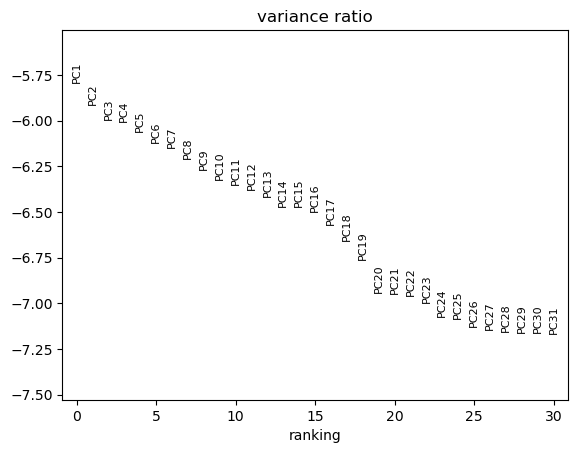

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


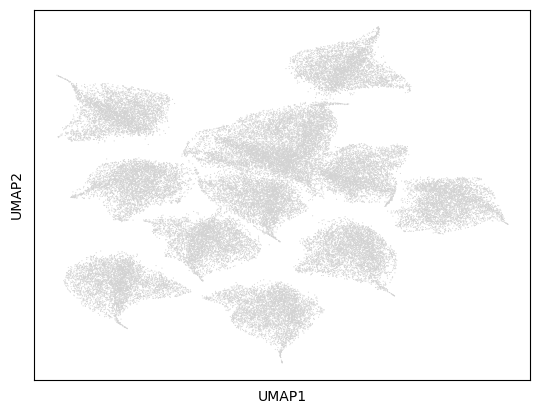

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


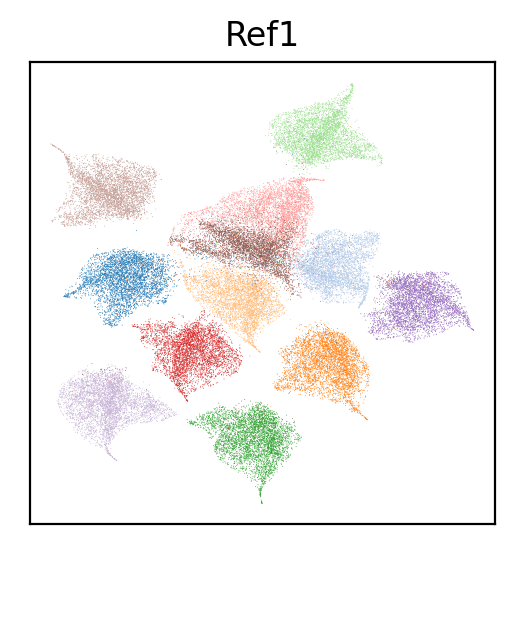

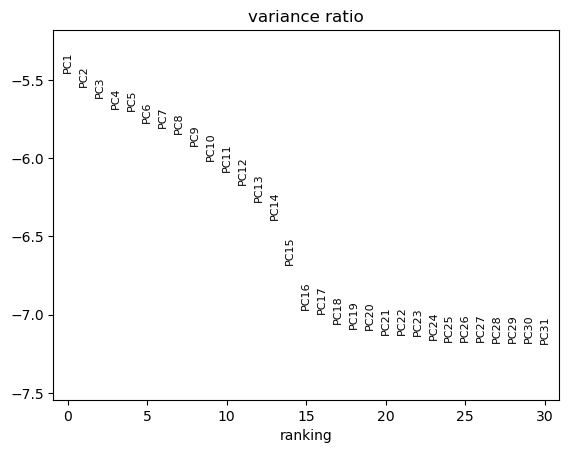

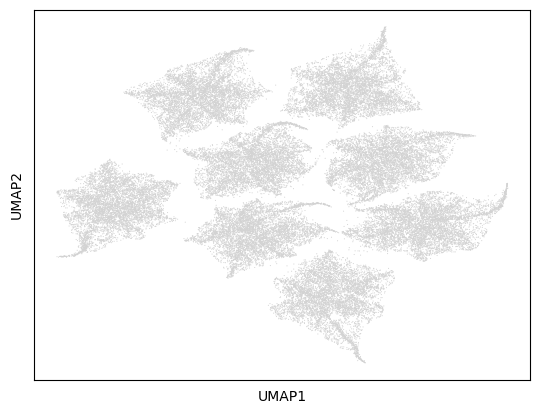

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


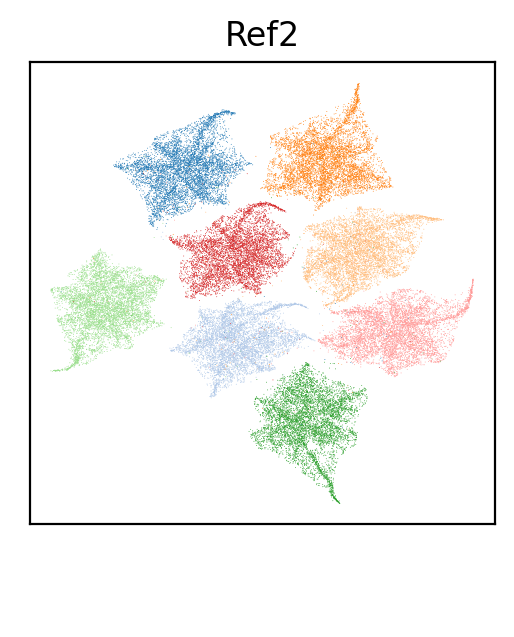

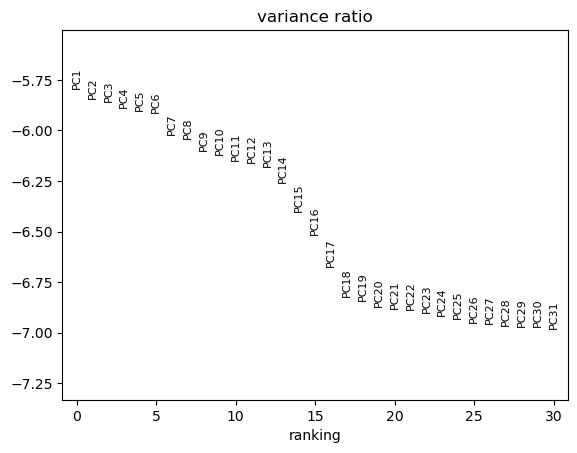

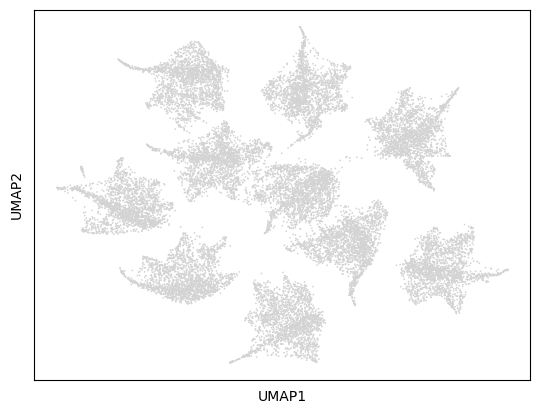

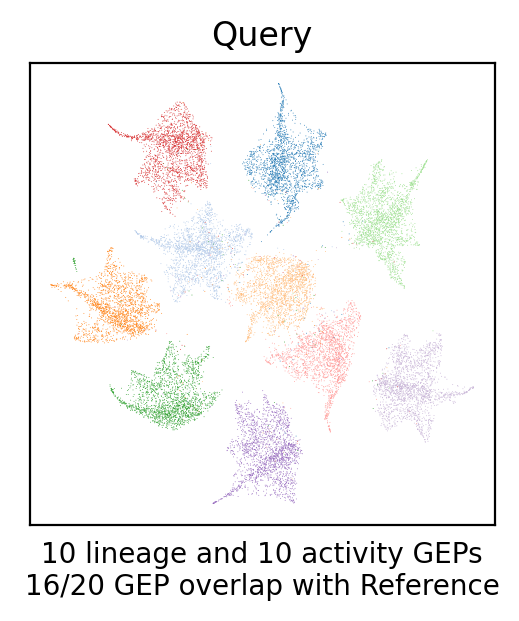

In [31]:
adatas = []
umaps = []
identity_map = dict(zip(np.arange(1,21), sns.color_palette("tab20")))
strmap = {'Ref1':'\n\n', 'Ref2':'\n\n', 'Query':'10 lineage and 10 activity GEPs\n16/20 GEP overlap with Reference'}
for (data, label) in [(simmod_ref1, 'Ref1'), (simmod_ref2, 'Ref2'), (simmod_query, 'Query')]:
    a = sc.AnnData(X=data.counts, obs=data.usage, var=data.geneparams)
    a = process(a)
    adatas.append(a)

    umap = pd.DataFrame(a.obsm['X_umap'], index=a.obs.index, columns=['U1', 'U2'])
    umap['identity'] = data.cellparams['Identity']
    umap['color'] = umap['identity'].apply(lambda x: identity_map[x])
    umaps.append(umap)

    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
    ax.scatter(umap['U1'], umap['U2'], c=umap['color'], s=.1, edgecolor='None')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label)
    
    ax.text(.5,-0.1,strmap[label], ha='center', va='center', transform=ax.transAxes)

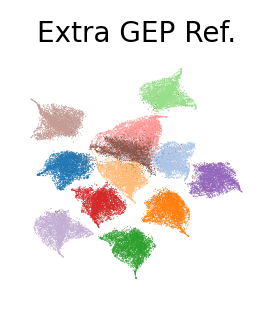

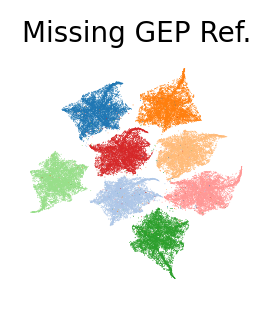

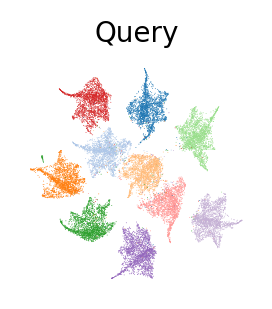

In [63]:
labels = ['Extra GEP Ref.', 'Missing GEP Ref.', 'Query']
for i in range(3):
    umap = umaps[i]

    (fig,ax) = plt.subplots(1,1, figsize=(1.5,1.5), dpi=200)
    ax.scatter(umap['U1'], umap['U2'], c=umap['color'], s=.1, edgecolor='None')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=10)
    ax.axis('off')
    
    #ax.text(.5,-0.1,strmap[label], ha='center', va='center', transform=ax.transAxes)

### Run cNMF for each dataset

In [32]:
def get_assignment(true_usages, inferred_usages):
    '''Get a mapping to reorder columns of inferred usage matrix
    to best match the columns of true usage matrix to allow easier comparison'''
    R = {}
    mapping = {}
    avail = set(true_usages.columns) # Set of programs to match
    toassign = set(inferred_usages.columns) #Set of programs to assign

    for i in inferred_usages.columns:
        R[i] = true_usages.corrwith(inferred_usages[i])
    
    R = pd.DataFrame.from_dict(R)
    Runst = R.unstack().reset_index()
    Runst.columns = ['learned', 'truth', 'corr']
    Runst = Runst.sort_values(by='corr', ascending=False)
    
    for i in Runst.index:
        if (Runst.loc[i, 'truth'] in avail) and (Runst.loc[i, 'learned'] in toassign):
            mapping[Runst.loc[i, 'learned']] = Runst.loc[i, 'truth']
            avail = avail - set([Runst.loc[i, 'truth']])
            toassign = toassign - set([Runst.loc[i, 'learned']])      
        
    
        if len(toassign) == 0:
            break
            
    return(mapping, R)


def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

def load_and_relabel(cobj, X, true_gep_means, K=11, ldthresh=0.07):
    res = {}
    hvgs = open(cobj.paths['nmf_genes_list']).read().split('\n')
    gene_scores_fn = cobj.paths['gene_spectra_tpm__txt'] % (K, str(ldthresh).replace('.','_'))
    gene_scores_Z_fn = cobj.paths['gene_spectra_score__txt'] % (K, str(ldthresh).replace('.','_'))
    
    gene_scores = pd.read_csv(gene_scores_fn, sep='\t', index_col=0)
    gene_scores = gene_scores.div(gene_scores.sum(axis=1), axis=0) * 1e6
    gene_scores_Z = pd.read_csv(gene_scores_Z_fn, sep='\t', index_col=0)

    
    stds = load_df_from_npz(cobj.paths['tpm_stats'])['__std']
    true_gep_means_hvgs = true_gep_means.loc[:, hvgs]
    gene_scores_hvgs = gene_scores.loc[:, hvgs]
    true_gep_means_hvgs_norm = true_gep_means_hvgs.div(stds.loc[hvgs], axis=1)    
    
    gene_scores_hvgs_norm = gene_scores_hvgs.div(stds.loc[hvgs], axis=1)
    assignmap, R = get_assignment(true_gep_means_hvgs_norm.T,
                                  gene_scores_hvgs_norm.T)
    
    fig,ax = plt.subplots(1,1, figsize=(3,3), dpi=200)
    gene_scores_hvgs_norm_relabeled = gene_scores_hvgs_norm.rename(index=assignmap)
    #gene_scores_hvgs_norm_relabeled.index = [int(x.replace('True_', '')) for x in gene_scores_hvgs_norm_relabeled.index]
    gene_scores_hvgs_norm_relabeled = gene_scores_hvgs_norm_relabeled.sort_index(axis=0)       
    
    R = df_col_corr(true_gep_means_hvgs_norm.T, gene_scores_hvgs_norm_relabeled.T)
    ax = sns.heatmap(R.sort_index(axis=1).sort_index(axis=0), xticklabels=True, yticklabels=True)
    ax.set_title('Spectra correlation')
    
    gene_scores_relabeled = gene_scores.rename(index=assignmap)
    gene_scores_relabeled = gene_scores_relabeled.sort_index(axis=0)   

    gene_scores_Z_relabeled = gene_scores_Z.rename(index=assignmap)
    gene_scores_Z_relabeled = gene_scores_Z_relabeled.sort_index(axis=0)     
    
    
    usage_fn = cobj.paths['consensus_usages__txt'] % (K, str(ldthresh).replace('.','_'))
    usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
    usage = usage.div(usage.sum(axis=1), axis=0)
    usage.columns = [int(x) for x in usage.columns]
    usage_relabeled = usage.rename(columns=assignmap)
    #usage_relabeled.columns = [int(x.replace('True_', '')) for x in usage_relabeled.columns]
    usage_relabeled = usage_relabeled.sort_index(axis=1)   
    #usage_relabeled.columns = ['cNMF_%d' % x for x in usage_relabeled.columns]    

    res = {'stds':stds, 'hvgs':hvgs, 'usage':usage_relabeled, 'tpm':gene_scores_relabeled, 'Z':gene_scores_Z_relabeled}
    return(res)

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=24.


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=16.


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=20.


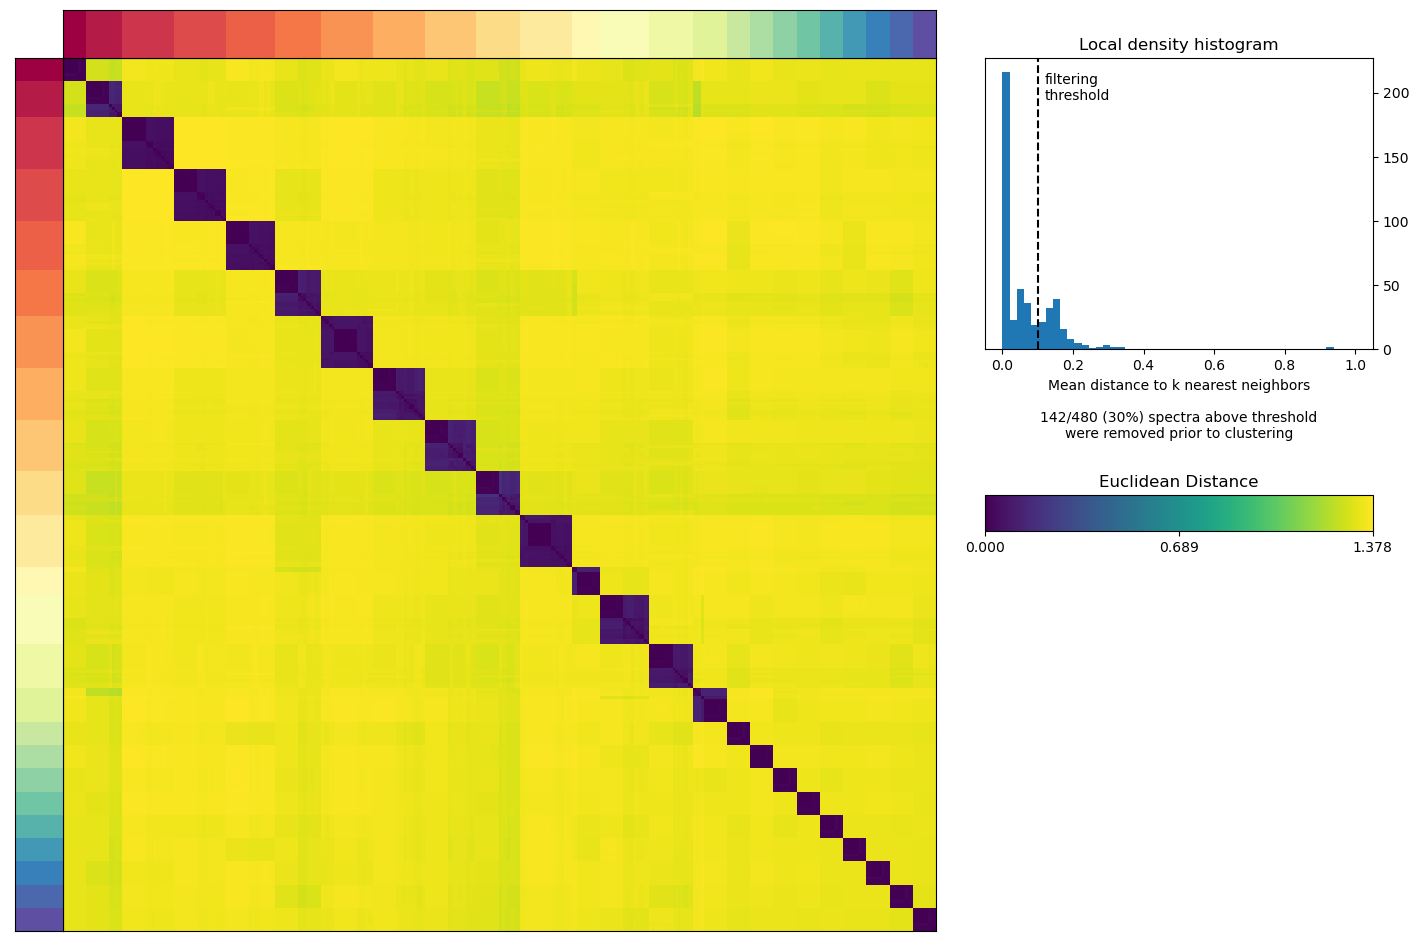

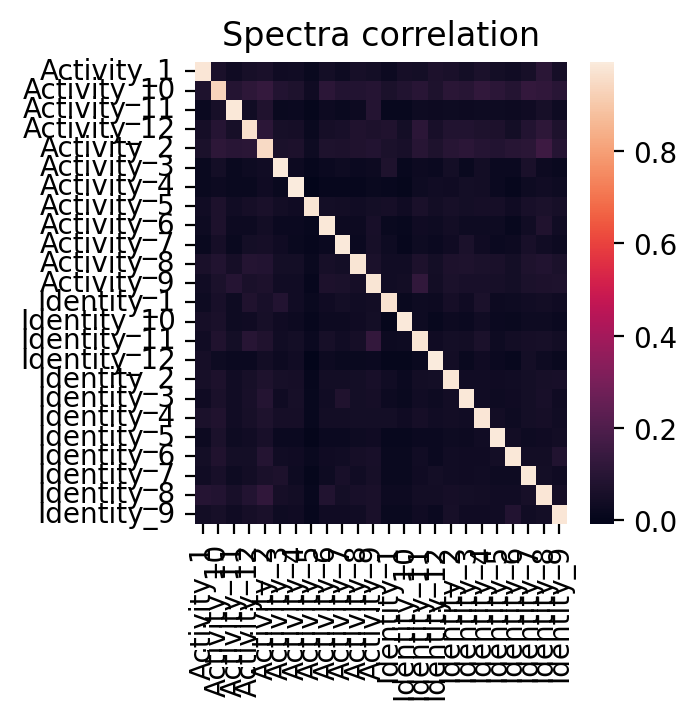

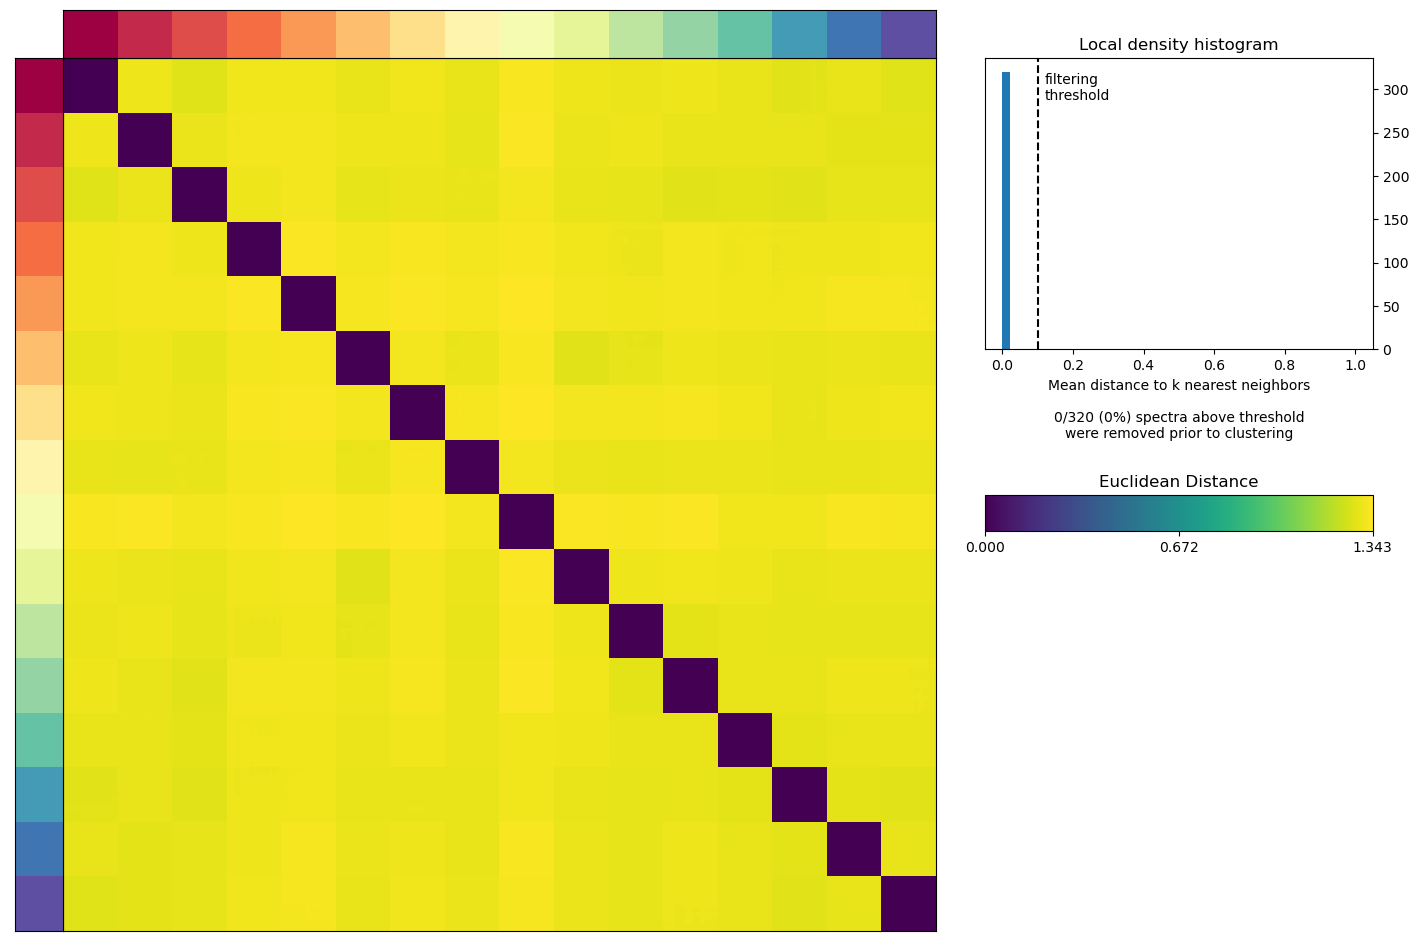

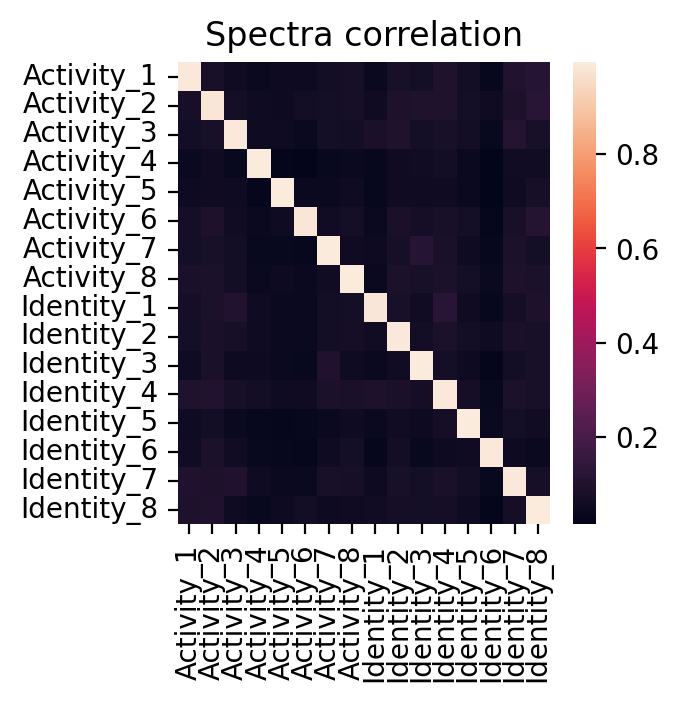

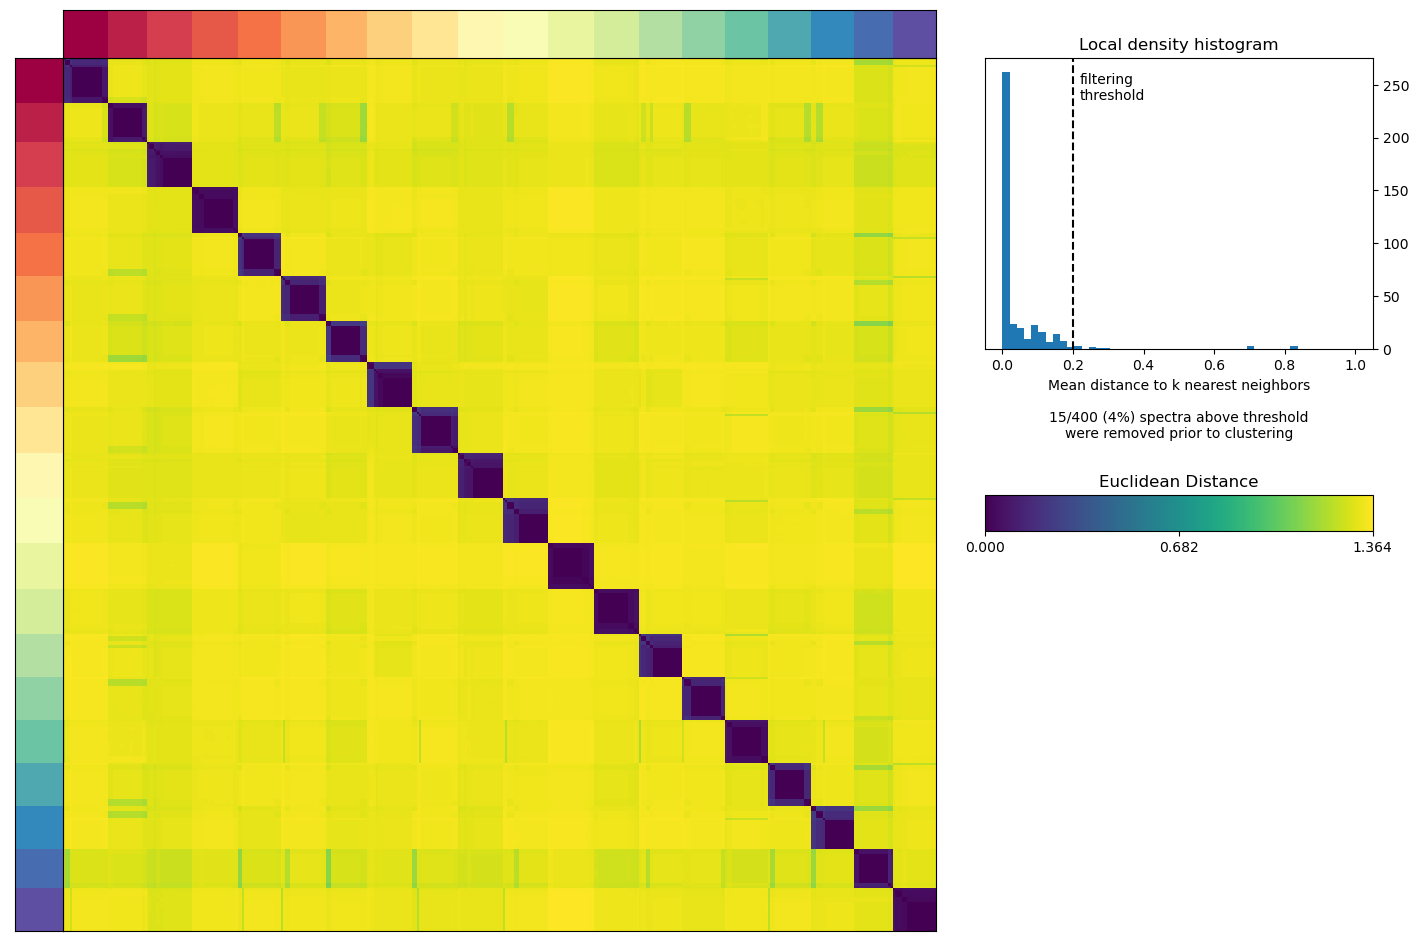

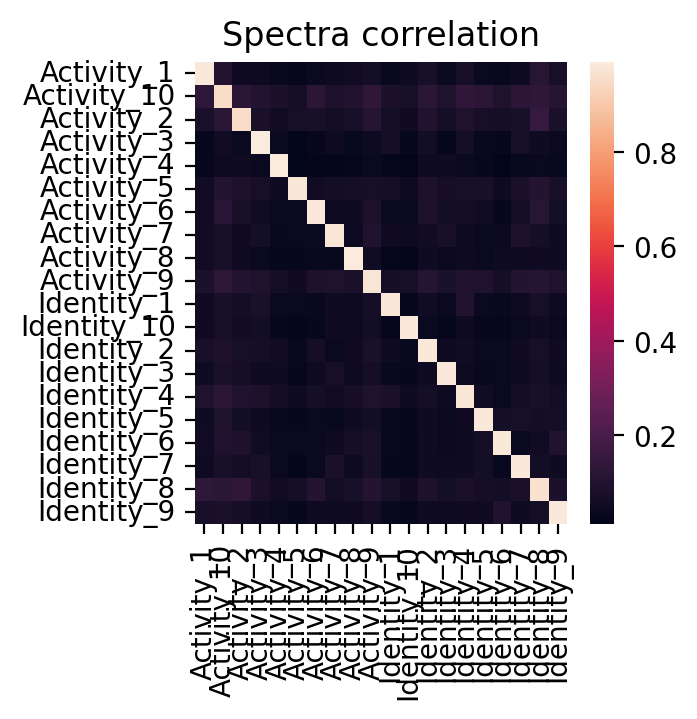

In [33]:
kmap = {'Ref1':24, 'Ref2':16, 'Query':20}
threshmap = {'Ref1':.1, 'Ref2':.1, 'Query':.2}
all_results = {}
for (data, label) in [(simmod_ref1, 'Ref1'),  (simmod_ref2, 'Ref2'), (simmod_query, 'Query')]:
    a = sc.AnnData(X=data.counts, obs=data.usage, var=data.spectra.T).copy()
    sc.pp.filter_genes(a, min_cells=5)
    countfn = '{d}/{lab}.counts.h5ad'.format(d=datadir, lab=label)
    sc.write(countfn, a)
    data.geneparams.to_csv('{d}/{lab}.geneparams.tsv'.format(d=datadir, lab=label), sep='\t')
    cnmf_obj = cNMF(output_dir=datadir, name=label)
    cnmf_obj.prepare(counts_fn=countfn, components=kmap[label], n_iter=20, seed=14, num_highvar_genes=1000)
    cnmf_obj.factorize()
    cnmf_obj.combine()
    cnmf_obj.consensus(k=kmap[label], local_neighborhood_size=0.3,
                       density_threshold=threshmap[label], show_clustering=True, refit_usage=True)
    
    X = pd.DataFrame(a.X, index=a.obs.index, columns=a.var.index)
    res = load_and_relabel(cnmf_obj, X, data.spectra, K=kmap[label], ldthresh=threshmap[label])
    all_results[label] = res

### Confirm relabeling worked

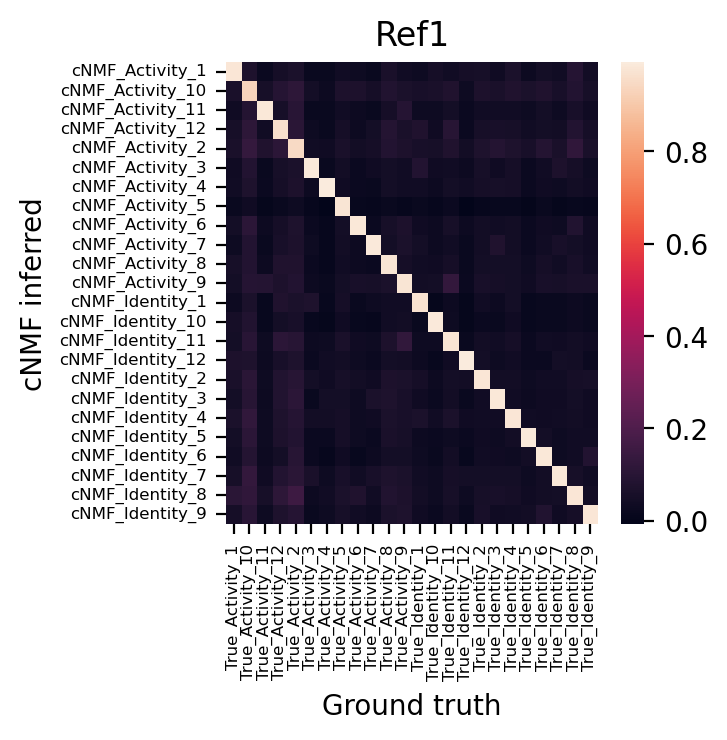

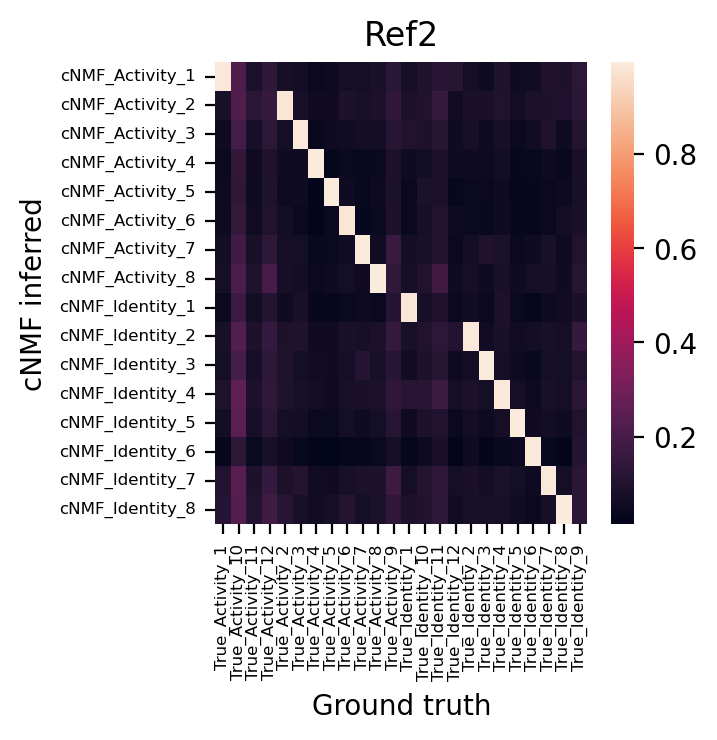

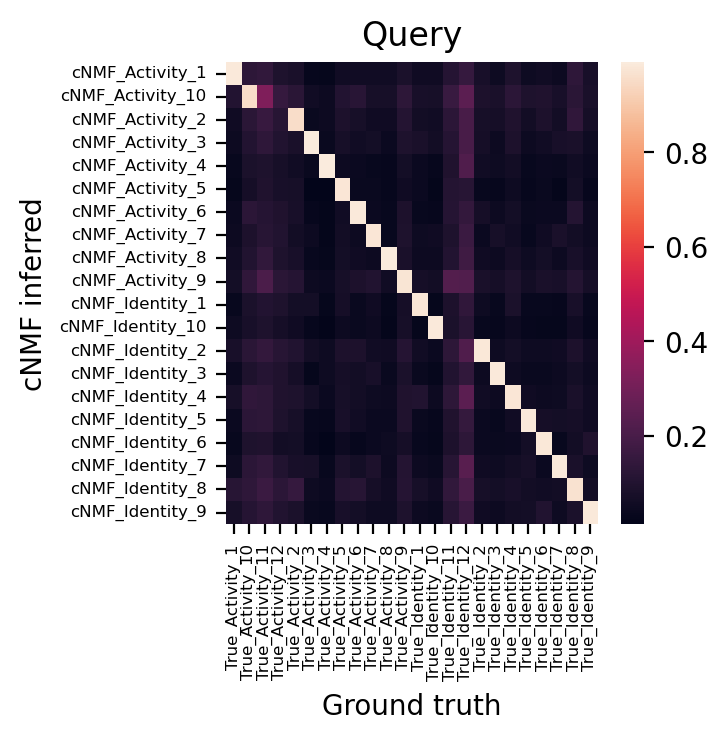

In [34]:
for (data, label) in [(simmod_ref1, 'Ref1'), (simmod_ref2, 'Ref2'), (simmod_query, 'Query')]:
    cnmf_tpm = all_results[label]['tpm'].copy()
    cnmf_tpm.index = ['cNMF_'+x for x in cnmf_tpm.index]
    true = simmod_catalog.spectra.copy()
    true.index = ['True_'+x for x in true.index]
    true = true.loc[:,all_results[label]['hvgs']]
    cnmf_tpm = cnmf_tpm.loc[:,all_results[label]['hvgs']]
    std = all_results[label]['stds'].loc[all_results[label]['hvgs']]
    true = true.div(std, axis=1)
    cnmf_tpm = cnmf_tpm.div(std, axis=1)
    
    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
    R = df_col_corr(cnmf_tpm.T, true.T).sort_index(axis=0).sort_index(axis=1)
    ax = sns.heatmap(R, ax=ax, xticklabels=True, yticklabels=True)
    ax.set_ylabel('cNMF inferred')
    ax.set_xlabel('Ground truth')
    ax.set_title(label)
    ax.set_xticklabels(R.columns, fontsize=6)
    ax.set_yticklabels(R.index, fontsize=6)

    


## Illustrate TCAT 

In [35]:
simmod_adata = sc.AnnData(X=simmod_query.counts, obs=simmod_query.usage, var=simmod_query.spectra.T).copy()

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [36]:
r = 'Ref1'
ref = all_results[r]['tpm'].copy()
ref = ref.loc[:, all_results[r]['hvgs']]
ref = ref.div(all_results[r]['stds'][ref.columns], axis=1)

In [37]:
tmod = TCAT(alpha=0, l1_ratio=0, tpm_norm=False, var_norm=True, copy=True)
rf_usage = tmod.fit_transform(simmod_adata, ref_spectra=ref)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

892 out of 1000 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [38]:
tcatorder = ['Identity_%d' % n for n in range(11, 13)]  + ['Activity_%d' % n for n in range(11,13)] 
tcatorder += ['Identity_%d' % n for n in range(1,11)]  + ['Activity_%d' % n for n in range(1,11)] 

Text(50.58159722222221, 0.5, 'TCAT Fit Usage')

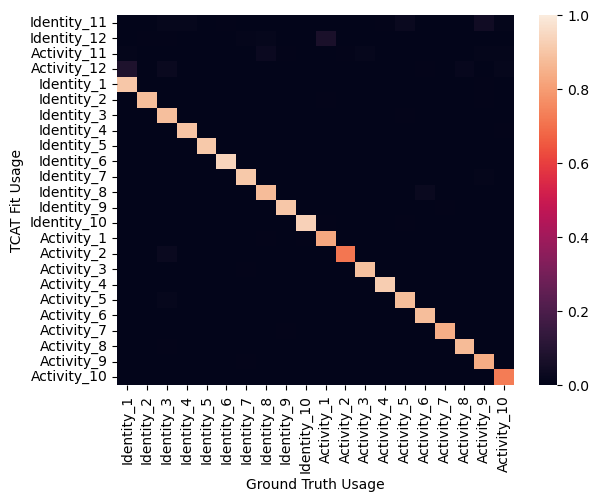

In [39]:
R_tcat_extra = df_col_corr(rf_usage_norm[tcatorder], simmod_query.usage)
ax = sns.heatmap(R_tcat_extra, vmin=0, vmax=1)
ax.set_xlabel('Ground Truth Usage')
ax.set_ylabel('TCAT Fit Usage')

In [49]:
r = 'Ref2'
ref = all_results[r]['tpm'].copy()
ref = ref.loc[:, all_results[r]['hvgs']]
ref = ref.div(all_results[r]['stds'][ref.columns], axis=1)

In [50]:
tmod = TCAT(alpha=0, l1_ratio=0, tpm_norm=False, var_norm=True, copy=True)
rf_usage = tmod.fit_transform(simmod_adata, ref_spectra=ref)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

893 out of 1000 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [51]:
tcatorder = ['Identity_%d' % n for n in range(1,9)]  + ['Activity_%d' % n for n in range(1,9)] 
usageorder = ['Identity_%d' % n for n in range(1,9)]  + ['Activity_%d' % n for n in range(1,9)] 
usageorder += ['Identity_%d' % n for n in range(9,11)]  + ['Activity_%d' % n for n in range(9,11)] 

Text(50.581597222222214, 0.5, 'TCAT Fit Usage')

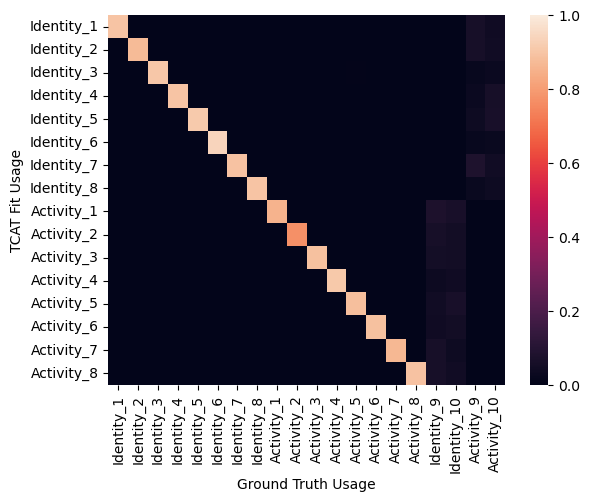

In [52]:
R_tcat_short = df_col_corr(rf_usage_norm[tcatorder], simmod_query.usage[usageorder])
ax = sns.heatmap(R_tcat_short, vmin=0, vmax=1)
ax.set_xlabel('Ground Truth Usage')
ax.set_ylabel('TCAT Fit Usage')

In [53]:
usageorder = ['Identity_%d' % n for n in range(1,11)]  + ['Activity_%d' % n for n in range(1,11)] 
R_cnmf = df_col_corr(all_results['Query']['usage'][usageorder], simmod_query.usage[usageorder])

Text(50.58159722222221, 0.5, 'cNMF Fit Usage')

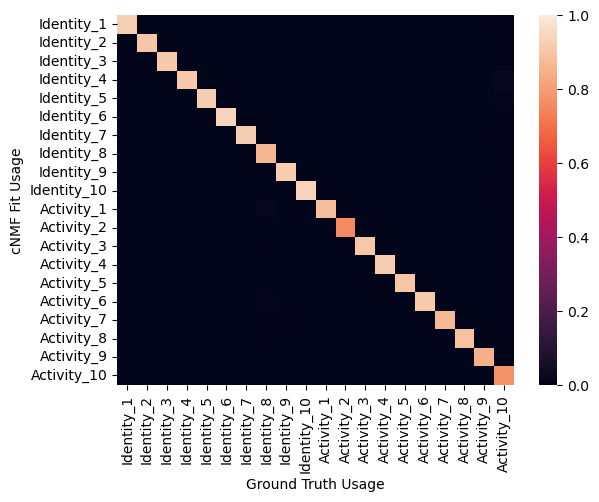

In [54]:
ax = sns.heatmap(R_cnmf, vmin=0, vmax=1)
ax.set_xlabel('Ground Truth Usage')
ax.set_ylabel('cNMF Fit Usage')

<AxesSubplot:xlabel='Source', ylabel='R'>

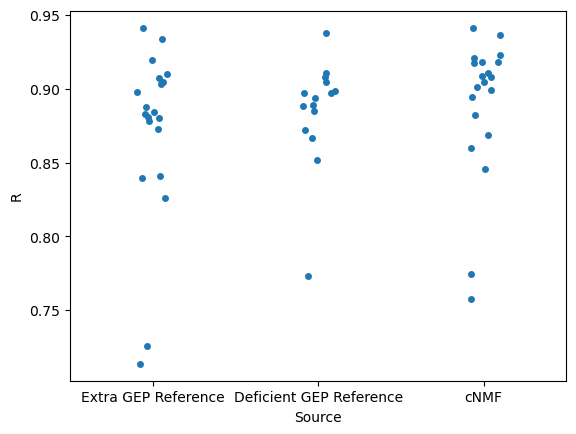

In [46]:
combined = pd.DataFrame(R_tcat_extra.iloc[4:,:].values[np.diag_indices(20)])
combined['Source'] = 'Extra GEP Reference'

r2 = pd.DataFrame(R_tcat_short.iloc[:,:-4].values[np.diag_indices(15)])
r2['Source'] = 'Deficient GEP Reference'


c2 = pd.DataFrame(R_cnmf.values[np.diag_indices(20)])
c2['Source'] = 'cNMF'

combined = pd.concat([combined, r2, c2], axis=0)
combined.columns = ['R', 'Source']

sns.stripplot(x='Source', y='R', data=combined)

In [65]:
from matplotlib import gridspec

Text(0.5, -0.3, 'Extra GEP Reference')

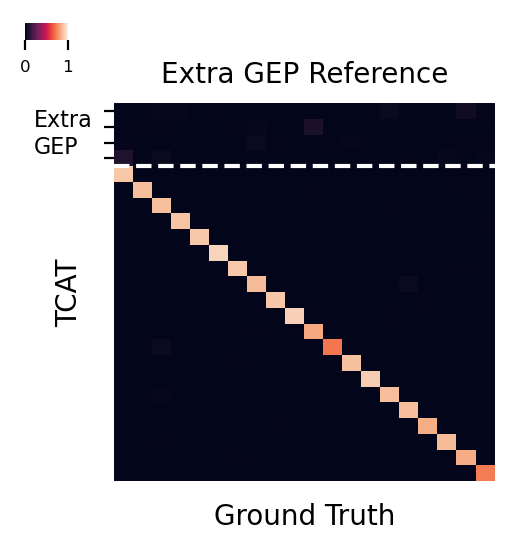

In [109]:

fig = plt.figure(figsize=(3, 3), dpi=200)

# Define the gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[0.1,0.9], height_ratios=[0.1,0.9])

# Create four axes based on the gridspec
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

cax = ax1.inset_axes([-0.1, .5, 1, 0.4], transform=ax1.transAxes)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')


#ax1.text(0, .85, 'Not in\nquery', fontsize=8)
#ax4.text(.0, .5, 'Not in\nref.', fontsize=8)


cax.tick_params(labelsize=6)

ax = sns.heatmap(R_tcat_extra, vmin=0, vmax=1, ax=ax4, cbar_ax=cax, cbar_kws={'orientation':'horizontal'})



ax4.set_xlabel('Ground Truth', fontsize=10)
ax4.set_ylabel('TCAT', fontsize=10)
ax.set_yticks([])
ax.set_xticks([])


ax.hlines(y=4, xmin=0, xmax=20, linestyle='--', color='w')
#ax.vlines(x=2, ymin=0, ymax=20, linestyle='--', color='w')

ax.set_yticks(np.array([1,2, 3, 4])-.5)
ax.set_yticklabels(['']*4)
#ax.set_xticks(np.array([1,2,3,4])-.5)
#ax.set_xticklabels(['']*4)

ax3.text(0.1, .92, 'Extra\nGEP', fontsize=8, va='center')
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])

ax2.text(0.5, -0.3, 'Extra GEP Reference', ha='center', va='center')

Text(0.5, -0.3, 'Missing GEP Reference')

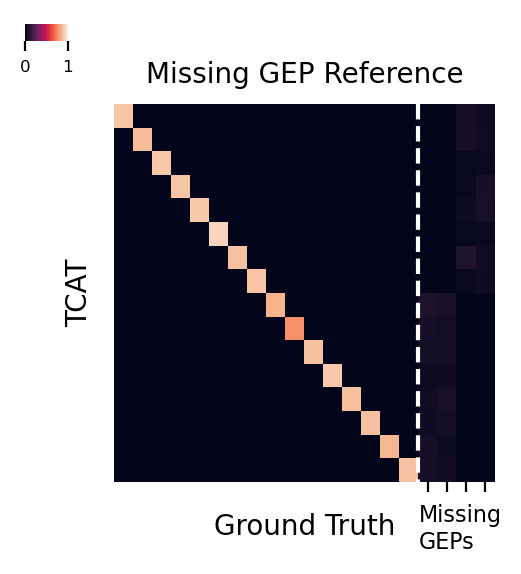

In [131]:

fig = plt.figure(figsize=(3, 3), dpi=200)

# Define the gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[0.1,0.9], height_ratios=[0.1,0.9])

# Create four axes based on the gridspec
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

cax = ax1.inset_axes([-0.1, .5, 1, 0.4], transform=ax1.transAxes)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')


#ax1.text(0, .85, 'Not in\nquery', fontsize=8)
#ax4.text(.0, .5, 'Not in\nref.', fontsize=8)


cax.tick_params(labelsize=6)

ax = sns.heatmap(R_tcat_short, vmin=0, vmax=1, ax=ax4, cbar_ax=cax, cbar_kws={'orientation':'horizontal'})



ax4.set_xlabel('Ground Truth', fontsize=10)
ax4.set_ylabel('TCAT', fontsize=10)
ax.set_yticks([])
ax.set_xticks([])


ax.vlines(x=16, ymin=0, ymax=20, linestyle='--', color='w')
#ax.vlines(x=2, ymin=0, ymax=20, linestyle='--', color='w')

ax.set_xticks(np.array([17,18, 19, 20])-.5)
ax.set_xticklabels(['']*4)
#ax.set_xticks(np.array([1,2,3,4])-.5)
#ax.set_xticklabels(['']*4)

ax4.text(16., 18, 'Missing\nGEPs', fontsize=8, va='center')
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])

ax2.text(0.5, -0.3, 'Missing GEP Reference', ha='center', va='center')